### Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import random
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from tqdm import tqdm
from time import sleep
from collections import OrderedDict
from more_itertools import chunked

n_shot = 1
n_class = 10
n_local_update = 5
batch_size = n_class

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TODO ↓消す
def batchnorm(input, weight=None, bias=None, running_mean=None, running_var=None, training=True, eps=1e-5, momentum=0.1):
    running_mean = torch.zeros(np.prod(np.array(input.data.size()[1]))).cuda()
    running_var = torch.ones(np.prod(np.array(input.data.size()[1]))).cuda()
    return F.batch_norm(input, running_mean, running_var, weight, bias, training, momentum, eps)


class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        
        self.h=64
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.fc = nn.Linear(self.h, n_class)

    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(x.size(0), self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    # for MAML local optimize
    def manual_forward(self, x, params):
        
        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        x = batchnorm(x, weight = params['bn1.weight'], bias = params['bn1.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        x = batchnorm(x, weight = params['bn2.weight'], bias = params['bn2.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        x = batchnorm(x, weight = params['bn3.weight'], bias = params['bn3.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = x.view(x.size(0), self.h)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)
        
        return x
    
    
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            
            test_loss += loss
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

### Dataset

In [2]:
class OmniglotOriginDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_index, transform):

        self.data = []
        self.path = path_to_lang
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # 各文字20枚ずつ入ってる
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### AugmentedDataset (for meta-train)

In [3]:
class OmniglotAugmentedDataset(Dataset):
    def __init__(self, path_to_chars, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError
        
        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_chars, train_indices)):
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # 各文字20枚ずつ入ってる
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### DataLoader

../data/omniglot_mini/images_background/Latin/


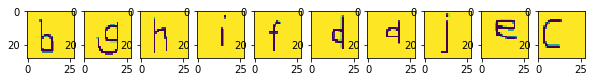

y_true: tensor([1, 6, 7, 8, 5, 3, 0, 9, 4, 2])


In [4]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

print(local_task_train_data_loader.dataset.path)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

### AugmentDataLoader

local_task_train_data


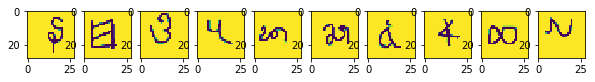

y_true: tensor([4, 0, 7, 6, 3, 5, 9, 2, 8, 1])

local_task_train_data


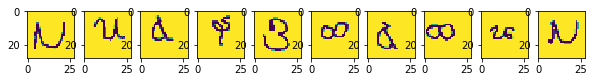

y_true: tensor([1, 6, 9, 4, 7, 8, 9, 8, 3, 1])


In [5]:
train_indices = np.random.randint(20, size=(n_class, n_shot))

path_to_chars = [
    '../data/omniglot_mini/images_background/Early_Aramaic/character08',
    '../data/omniglot_mini/images_background/N_Ko/character05',
    '../data/omniglot_mini/images_background/Early_Aramaic/character01',
    '../data/omniglot_mini/images_background/Balinese/character04',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character21',
    '../data/omniglot_mini/images_background/Balinese/character03',
    '../data/omniglot_mini/images_background/Gujarati/character35',
    '../data/omniglot_mini/images_background/Bengali/character10',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character18',
    '../data/omniglot_mini/images_background/Armenian/character17'
]

print("local_task_train_data")
local_task_train_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=True,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

print("\nlocal_task_train_data")
local_task_test_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=False,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break

### (fitting, task=Latin, n_class=10, n_shot=1)

100%|██████████| 10/10 [00:00<00:00, 49.54it/s, epoch=10, train_loss=0.0878, train_acc=1, test_loss=2.07, test_acc=0.311]


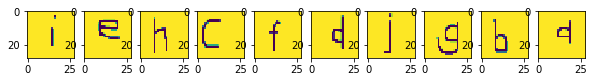

y_pred: tensor([8, 4, 7, 2, 5, 3, 9, 6, 1, 0])
y_true: tensor([8, 4, 7, 2, 5, 3, 9, 6, 1, 0])


In [6]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)


local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(10)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

### (fitting, task=MNIST, n_class=10, n_shot=1)

100%|██████████| 1/1 [00:15<00:00, 15.39s/it, epoch=1, train_loss=0.0147, train_acc=0.963, test_loss=0.0679, test_acc=0.979]


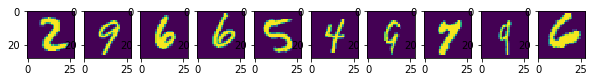

y_pred: tensor([2, 9, 6, 6, 5, 4, 9, 7, 9, 6])
y_true: tensor([2, 9, 6, 6, 5, 4, 9, 7, 9, 6])


In [7]:
local_task_train_data_loader = DataLoader(
    datasets.MNIST('../data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

local_task_test_data_loader = DataLoader(
    datasets.MNIST('../data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(1)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

### Taskset and TaskLoader classes

In [4]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return len(self.taskset)

### Taskset

In [5]:
class OmniglotOriginTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_langs))
        tasks = [os.path.join(path_to_langs, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=n_class]
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_index=[np.random.randint(20)] #TODO chanege indices
        return {"train":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx], 
                                    n_class=n_class,
                                    train=True,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx],
                                    n_class=n_class,
                                    train=False,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### AugmentedTaskset (for meta-train)

In [6]:
class OmniglotAugmentedTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
            
        chars = []
        
        for path_to_lang in os.listdir(path_to_langs):
            path_to_chars = os.path.join(path_to_langs, path_to_lang)
            for path_to_char in os.listdir(path_to_chars):
                chars.append(os.path.join(path_to_chars, path_to_char)) 
        
        random.shuffle(chars)
        tasks = list(chunked(chars, n_class))[:-1] # drop_last
        
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_indices = np.random.randint(20, size=(n_class, n_shot))
        return {"train":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### TaskLoader

30
../data/omniglot_mini/images_background/Anglo-Saxon_Futhorc


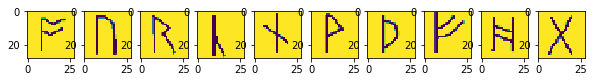

tensor([3, 1, 4, 5, 9, 7, 2, 0, 8, 6])
../data/omniglot_mini/images_background/Cyrillic


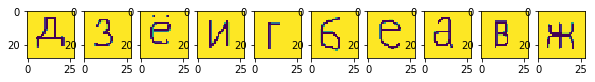

tensor([4, 8, 6, 9, 3, 1, 5, 0, 2, 7])
../data/omniglot_mini/images_background/Malay_(Jawi_-_Arabic)


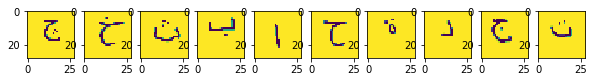

tensor([7, 8, 4, 1, 0, 6, 3, 9, 5, 2])


In [7]:
meta_train_task_loader = TaskLoader(
    OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    print("test")
    local_task_train_data_loader = meta_train_task["test"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
        break
    if i==1:
        break

### AugmentTaskLoader

96
['../data/omniglot_mini/images_background/Early_Aramaic/character18', '../data/omniglot_mini/images_background/Bengali/character46', '../data/omniglot_mini/images_background/Arcadian/character08', '../data/omniglot_mini/images_background/Latin/character02', '../data/omniglot_mini/images_background/Braille/character13', '../data/omniglot_mini/images_background/Japanese_(katakana)/character33', '../data/omniglot_mini/images_background/Armenian/character23', '../data/omniglot_mini/images_background/Japanese_(hiragana)/character05', '../data/omniglot_mini/images_background/N_Ko/character13', '../data/omniglot_mini/images_background/Japanese_(hiragana)/character49']
train


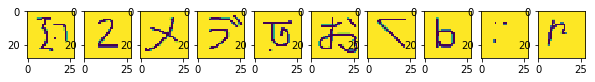

tensor([2, 6, 5, 9, 1, 7, 8, 3, 4, 0])
test


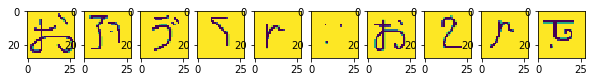

tensor([7, 2, 9, 8, 0, 4, 7, 6, 0, 1])
['../data/omniglot_mini/images_background/Asomtavruli_(Georgian)/character04', '../data/omniglot_mini/images_background/Bengali/character23', '../data/omniglot_mini/images_background/Japanese_(hiragana)/character33', '../data/omniglot_mini/images_background/Sanskrit/character41', '../data/omniglot_mini/images_background/Early_Aramaic/character04', '../data/omniglot_mini/images_background/Syriac_(Estrangelo)/character22', '../data/omniglot_mini/images_background/Grantha/character39', '../data/omniglot_mini/images_background/Japanese_(katakana)/character05', '../data/omniglot_mini/images_background/Gujarati/character35', '../data/omniglot_mini/images_background/Futurama/character08']
train


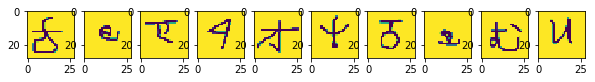

tensor([1, 6, 3, 4, 7, 9, 0, 5, 2, 8])
test


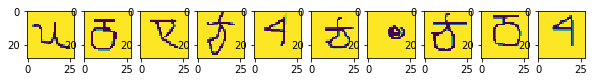

tensor([8, 0, 3, 1, 4, 1, 6, 1, 0, 4])


In [8]:
meta_train_task_loader = TaskLoader(
    OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    print("test")
    local_task_test_data_loader = meta_train_task["test"]
    for data, target in local_task_test_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
        break
    if i==1:
        break

---

# MAML

In [9]:
class MetaLearner(object):
    def __init__(self):
        self.lr = 0.1
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def save(self, model_path):
        torch.save(self.master_net.state_dict(), model_path)
    
    def load(self, model_path):
        self.master_net.load_state_dict(torch.load(model_path))
    
    def meta_test(self):
        
        meta_test_task_loader = TaskLoader(
            OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        test_loss, test_acc = [], []
        
        sleep(0.5)
        with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
            for meta_test_task in _tqdm:

                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)
                faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)

                # make local task data loader
                local_task_train_data_loader = meta_test_task["train"]
                local_task_test_data_loader = meta_test_task["test"]

                # ----------------------------------------------------------------
                # meta test task train
                # ----------------------------------------------------------------

                for epoch in range(n_local_update):
                    _train_loss, _train_acc = train(
                        faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                # ----------------------------------------------------------------
                # meta test task test
                # ----------------------------------------------------------------

                _test_loss, _test_acc = test(faster_net, self.device, local_task_test_data_loader)
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        return np.mean(test_loss), np.mean(test_acc)

    
    def meta_train(self):
        
        meta_train_task_loader = TaskLoader(
            OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
    
        meta_grads = []
        
        test_loss, test_acc = [], []
        
        sleep(0.5)
        with tqdm(meta_train_task_loader, desc="Meta Train", ncols=10) as _tqdm:
            for meta_train_task in _tqdm:
                
                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)

                faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())
                master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())

                # make local task data loader
                local_task_train_data_loader = meta_train_task["train"]
                local_task_test_data_loader = meta_train_task["test"]

                # ----------------------------------------------------------------
                # meta train task train
                # ----------------------------------------------------------------

                first_train_for_this_task = True

                for epoch in range(n_local_update):
                    
                    _train_loss = 0
                    _train_acc = 0
                    
                    for data, target in local_task_train_data_loader:
                        data, target = data.to(self.device), target.to(self.device)

                        if first_train_for_this_task:
                            
                            # manual predict
                            output = self.master_net(data)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                            
                            grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                            first_train_for_this_task = False

                        else:
                            # manual predict
                            output = faster_net.manual_forward(data, faster_params)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                                                        
                            grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)
        
                        # manual optimize!!!
                        faster_params = OrderedDict(
                            (name, param - self.lr*grad)
                            for ((name, param), grad) in zip(faster_params.items(), grads)
                        )
                    
                    _train_loss /= len(local_task_train_data_loader.dataset)
                    _train_acc /= len(local_task_train_data_loader.dataset)
                    
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                
                # ----------------------------------------------------------------
                # meta train task test
                # ----------------------------------------------------------------
                
                _test_loss = 0
                _test_acc = 0
                
                for data, target in local_task_test_data_loader:
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)
                    loss = F.nll_loss(output, target) # test_loss計算するとこまではfaster_net

                    # differentiates test_loss by master_net params
                    grads = torch.autograd.grad(loss, self.master_net.parameters(), retain_graph=True)
                    grads = {name:g for ((name, _), g) in zip(faster_net.named_parameters(), grads)}
                    meta_grads.append(grads)

                    pred = output.max(1, keepdim=True)[1]
                    acc = pred.eq(target.view_as(pred)).sum()
                    
                    _test_loss += loss.item()
                    _test_acc += acc.item()
                
                _test_loss /= len(local_task_test_data_loader.dataset)
                _test_acc /= len(local_task_test_data_loader.dataset)  
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        # ----------------------------------------------------------------
        # end all tasks
        # ----------------------------------------------------------------
        
        # ----------------------------------------------------------------
        # meta update
        # ----------------------------------------------------------------
        
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}
        
        # using data,target from somewhere
        dumy_output = self.master_net(data)
        dumy_loss = F.nll_loss(dumy_output, target)
        
        # after dumy_loss.backward, rewrite grads
        self.master_opt.zero_grad()
        dumy_loss.backward(retain_graph=True)

        hooks = []
        for (k,v) in self.master_net.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return meta_grads[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))

        # Compute grads for current step, replace with summed gradients as defined by hook
        self.master_opt.zero_grad()
        dumy_loss.backward()

        # Update the net parameters with the accumulated gradient according to optimizer
        self.master_opt.step()

        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

        return np.mean(test_loss), np.mean(test_acc)

In [10]:
meta_learner = MetaLearner()

# see normal few-shot learning
for _ in range(1):
    test_loss, test_acc = meta_learner.meta_test()
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        0, test_loss, test_acc))

for epoch in range(1000):
    
    train_loss, train_acc = meta_learner.meta_train()
    test_loss, test_acc = meta_learner.meta_test()
    
    print("# {} (meta-train-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, train_loss, train_acc))    
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, test_loss, test_acc))
    
    model_path = "../model/model-epoch_{:05}-train_loss_{:0.3f}-train_acc_{:0.3f}-test_loss_{:0.3f}-test_acc_{:0.3f}.pt".format(
        epoch, train_loss, train_acc, test_loss, test_acc)
    
    meta_learner.save(model_path)
    meta_learner.load(model_path)

Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.057, train_acc=1.000]


# 1 (meta-train-task) test_loss: 0.187075, test_acc: 0.491996
# 1  (meta-test-task) test_loss: 1.946103, test_acc: 0.381579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.036, train_acc=1.000]


# 2 (meta-train-task) test_loss: 0.186854, test_acc: 0.485691
# 2  (meta-test-task) test_loss: 1.909627, test_acc: 0.415000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 3 (meta-train-task) test_loss: 0.185483, test_acc: 0.500110
# 3  (meta-test-task) test_loss: 1.914087, test_acc: 0.406053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 4 (meta-train-task) test_loss: 0.183185, test_acc: 0.514090
# 4  (meta-test-task) test_loss: 1.892184, test_acc: 0.408421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.76it/s, epoch=5, train_loss=0.045, train_acc=1.000]


# 5 (meta-train-task) test_loss: 0.182146, test_acc: 0.518092
# 5  (meta-test-task) test_loss: 1.914067, test_acc: 0.400263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.041, train_acc=1.000]


# 6 (meta-train-task) test_loss: 0.179695, test_acc: 0.538103
# 6  (meta-test-task) test_loss: 1.887611, test_acc: 0.414474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 7 (meta-train-task) test_loss: 0.177611, test_acc: 0.548410
# 7  (meta-test-task) test_loss: 1.852755, test_acc: 0.432105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.051, train_acc=1.000]


# 8 (meta-train-task) test_loss: 0.177746, test_acc: 0.545614
# 8  (meta-test-task) test_loss: 1.803249, test_acc: 0.464474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.55it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 9 (meta-train-task) test_loss: 0.175405, test_acc: 0.565844
# 9  (meta-test-task) test_loss: 1.887781, test_acc: 0.408158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.17it/s, epoch=5, train_loss=0.086, train_acc=1.000]


# 10 (meta-train-task) test_loss: 0.173984, test_acc: 0.573300
# 10  (meta-test-task) test_loss: 1.802236, test_acc: 0.469211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.46it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 11 (meta-train-task) test_loss: 0.172872, test_acc: 0.573520
# 11  (meta-test-task) test_loss: 1.816170, test_acc: 0.469737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.49it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 12 (meta-train-task) test_loss: 0.172681, test_acc: 0.578289
# 12  (meta-test-task) test_loss: 1.798154, test_acc: 0.471316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 13 (meta-train-task) test_loss: 0.170329, test_acc: 0.593750
# 13  (meta-test-task) test_loss: 1.787825, test_acc: 0.481579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 14 (meta-train-task) test_loss: 0.168819, test_acc: 0.605757
# 14  (meta-test-task) test_loss: 1.775625, test_acc: 0.486842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.44it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 15 (meta-train-task) test_loss: 0.167813, test_acc: 0.600384
# 15  (meta-test-task) test_loss: 1.753828, test_acc: 0.497105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 16 (meta-train-task) test_loss: 0.167314, test_acc: 0.606031
# 16  (meta-test-task) test_loss: 1.734008, test_acc: 0.502895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.56it/s, epoch=5, train_loss=0.054, train_acc=1.000]


# 17 (meta-train-task) test_loss: 0.165252, test_acc: 0.619298
# 17  (meta-test-task) test_loss: 1.733991, test_acc: 0.505789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 18 (meta-train-task) test_loss: 0.164875, test_acc: 0.615461
# 18  (meta-test-task) test_loss: 1.769141, test_acc: 0.479474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.96it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 19 (meta-train-task) test_loss: 0.162514, test_acc: 0.631743
# 19  (meta-test-task) test_loss: 1.705794, test_acc: 0.519737


Meta Test : 100%|█| 20/20 [00:01<00:00, 11.45it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 20 (meta-train-task) test_loss: 0.161378, test_acc: 0.637445
# 20  (meta-test-task) test_loss: 1.753370, test_acc: 0.488421


Meta Test : 100%|█| 20/20 [00:01<00:00, 14.36it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 21 (meta-train-task) test_loss: 0.160974, test_acc: 0.639145
# 21  (meta-test-task) test_loss: 1.684429, test_acc: 0.534737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.87it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 22 (meta-train-task) test_loss: 0.160212, test_acc: 0.637719
# 22  (meta-test-task) test_loss: 1.700697, test_acc: 0.536053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 23 (meta-train-task) test_loss: 0.158175, test_acc: 0.649287
# 23  (meta-test-task) test_loss: 1.672521, test_acc: 0.531579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.11it/s, epoch=5, train_loss=0.036, train_acc=1.000]


# 24 (meta-train-task) test_loss: 0.155872, test_acc: 0.667160
# 24  (meta-test-task) test_loss: 1.703674, test_acc: 0.526053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.04it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 25 (meta-train-task) test_loss: 0.155525, test_acc: 0.666557
# 25  (meta-test-task) test_loss: 1.661618, test_acc: 0.541842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.00it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 26 (meta-train-task) test_loss: 0.153770, test_acc: 0.677029
# 26  (meta-test-task) test_loss: 1.663316, test_acc: 0.538947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.29it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 27 (meta-train-task) test_loss: 0.153325, test_acc: 0.671491
# 27  (meta-test-task) test_loss: 1.682659, test_acc: 0.521053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 28 (meta-train-task) test_loss: 0.151498, test_acc: 0.683388
# 28  (meta-test-task) test_loss: 1.687349, test_acc: 0.531316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 29 (meta-train-task) test_loss: 0.151280, test_acc: 0.688048
# 29  (meta-test-task) test_loss: 1.600350, test_acc: 0.582368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.29it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 30 (meta-train-task) test_loss: 0.148817, test_acc: 0.703454
# 30  (meta-test-task) test_loss: 1.606244, test_acc: 0.562895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.65it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 31 (meta-train-task) test_loss: 0.150107, test_acc: 0.682566
# 31  (meta-test-task) test_loss: 1.652738, test_acc: 0.536316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.18it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 32 (meta-train-task) test_loss: 0.147984, test_acc: 0.692105
# 32  (meta-test-task) test_loss: 1.625296, test_acc: 0.563158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 33 (meta-train-task) test_loss: 0.148226, test_acc: 0.695011
# 33  (meta-test-task) test_loss: 1.621744, test_acc: 0.554474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.65it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 34 (meta-train-task) test_loss: 0.147006, test_acc: 0.697423
# 34  (meta-test-task) test_loss: 1.616732, test_acc: 0.564474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 35 (meta-train-task) test_loss: 0.145300, test_acc: 0.706798
# 35  (meta-test-task) test_loss: 1.587793, test_acc: 0.573158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.56it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 36 (meta-train-task) test_loss: 0.144779, test_acc: 0.703564
# 36  (meta-test-task) test_loss: 1.615270, test_acc: 0.543421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 37 (meta-train-task) test_loss: 0.143753, test_acc: 0.705208
# 37  (meta-test-task) test_loss: 1.591753, test_acc: 0.570000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 38 (meta-train-task) test_loss: 0.142108, test_acc: 0.722533
# 38  (meta-test-task) test_loss: 1.645851, test_acc: 0.513158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 39 (meta-train-task) test_loss: 0.141693, test_acc: 0.719737
# 39  (meta-test-task) test_loss: 1.601100, test_acc: 0.555526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 40 (meta-train-task) test_loss: 0.141462, test_acc: 0.721162
# 40  (meta-test-task) test_loss: 1.595633, test_acc: 0.565789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 41 (meta-train-task) test_loss: 0.140522, test_acc: 0.725000
# 41  (meta-test-task) test_loss: 1.584411, test_acc: 0.563947


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.10it/s, epoch=5, train_loss=0.039, train_acc=1.000]


# 42 (meta-train-task) test_loss: 0.139840, test_acc: 0.728344
# 42  (meta-test-task) test_loss: 1.611404, test_acc: 0.538421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 43 (meta-train-task) test_loss: 0.139521, test_acc: 0.726042
# 43  (meta-test-task) test_loss: 1.612095, test_acc: 0.540789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 44 (meta-train-task) test_loss: 0.137773, test_acc: 0.732072
# 44  (meta-test-task) test_loss: 1.552411, test_acc: 0.568684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 45 (meta-train-task) test_loss: 0.137361, test_acc: 0.731908
# 45  (meta-test-task) test_loss: 1.533529, test_acc: 0.587368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 46 (meta-train-task) test_loss: 0.136680, test_acc: 0.740132
# 46  (meta-test-task) test_loss: 1.528798, test_acc: 0.588684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 47 (meta-train-task) test_loss: 0.135871, test_acc: 0.738980
# 47  (meta-test-task) test_loss: 1.578581, test_acc: 0.550000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.94it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 48 (meta-train-task) test_loss: 0.134987, test_acc: 0.744189
# 48  (meta-test-task) test_loss: 1.550080, test_acc: 0.574474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 49 (meta-train-task) test_loss: 0.135039, test_acc: 0.739254
# 49  (meta-test-task) test_loss: 1.504745, test_acc: 0.603947


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.97it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 50 (meta-train-task) test_loss: 0.134265, test_acc: 0.741338
# 50  (meta-test-task) test_loss: 1.519984, test_acc: 0.580263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 51 (meta-train-task) test_loss: 0.134654, test_acc: 0.737116
# 51  (meta-test-task) test_loss: 1.559473, test_acc: 0.556316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.78it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 52 (meta-train-task) test_loss: 0.132252, test_acc: 0.756305
# 52  (meta-test-task) test_loss: 1.495459, test_acc: 0.598421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 53 (meta-train-task) test_loss: 0.132195, test_acc: 0.745998
# 53  (meta-test-task) test_loss: 1.520520, test_acc: 0.587895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.02it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 54 (meta-train-task) test_loss: 0.132207, test_acc: 0.752961
# 54  (meta-test-task) test_loss: 1.545399, test_acc: 0.572105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.18it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 55 (meta-train-task) test_loss: 0.131926, test_acc: 0.751864
# 55  (meta-test-task) test_loss: 1.519200, test_acc: 0.576053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 56 (meta-train-task) test_loss: 0.131695, test_acc: 0.749781
# 56  (meta-test-task) test_loss: 1.487680, test_acc: 0.603684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.14it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 57 (meta-train-task) test_loss: 0.130591, test_acc: 0.752303
# 57  (meta-test-task) test_loss: 1.413840, test_acc: 0.655526


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.02it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 58 (meta-train-task) test_loss: 0.130868, test_acc: 0.752577
# 58  (meta-test-task) test_loss: 1.502357, test_acc: 0.580263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 59 (meta-train-task) test_loss: 0.129518, test_acc: 0.756524
# 59  (meta-test-task) test_loss: 1.474765, test_acc: 0.602632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 60 (meta-train-task) test_loss: 0.129613, test_acc: 0.754057
# 60  (meta-test-task) test_loss: 1.496779, test_acc: 0.595263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.23it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 61 (meta-train-task) test_loss: 0.129913, test_acc: 0.751700
# 61  (meta-test-task) test_loss: 1.484444, test_acc: 0.597895


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.02it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 62 (meta-train-task) test_loss: 0.128196, test_acc: 0.757675
# 62  (meta-test-task) test_loss: 1.502008, test_acc: 0.590789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 63 (meta-train-task) test_loss: 0.128536, test_acc: 0.764200
# 63  (meta-test-task) test_loss: 1.496064, test_acc: 0.593158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 64 (meta-train-task) test_loss: 0.126218, test_acc: 0.768092
# 64  (meta-test-task) test_loss: 1.429135, test_acc: 0.630526


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.14it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 65 (meta-train-task) test_loss: 0.126470, test_acc: 0.768860
# 65  (meta-test-task) test_loss: 1.459425, test_acc: 0.617368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.68it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 66 (meta-train-task) test_loss: 0.127806, test_acc: 0.760746
# 66  (meta-test-task) test_loss: 1.445418, test_acc: 0.621842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.34it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 67 (meta-train-task) test_loss: 0.127034, test_acc: 0.762884
# 67  (meta-test-task) test_loss: 1.444577, test_acc: 0.616842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.92it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 68 (meta-train-task) test_loss: 0.126098, test_acc: 0.764638
# 68  (meta-test-task) test_loss: 1.396096, test_acc: 0.644211


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.08it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 69 (meta-train-task) test_loss: 0.125190, test_acc: 0.770340
# 69  (meta-test-task) test_loss: 1.473294, test_acc: 0.589211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 70 (meta-train-task) test_loss: 0.126056, test_acc: 0.762939
# 70  (meta-test-task) test_loss: 1.391053, test_acc: 0.647632


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.01it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 71 (meta-train-task) test_loss: 0.124453, test_acc: 0.773246
# 71  (meta-test-task) test_loss: 1.443172, test_acc: 0.621842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 72 (meta-train-task) test_loss: 0.124448, test_acc: 0.775877
# 72  (meta-test-task) test_loss: 1.529997, test_acc: 0.563158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.58it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 73 (meta-train-task) test_loss: 0.124424, test_acc: 0.770011
# 73  (meta-test-task) test_loss: 1.488569, test_acc: 0.605000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.06it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 74 (meta-train-task) test_loss: 0.123296, test_acc: 0.778070
# 74  (meta-test-task) test_loss: 1.439446, test_acc: 0.601842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.02it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 75 (meta-train-task) test_loss: 0.123020, test_acc: 0.772807
# 75  (meta-test-task) test_loss: 1.458687, test_acc: 0.614211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.97it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 76 (meta-train-task) test_loss: 0.122026, test_acc: 0.781140
# 76  (meta-test-task) test_loss: 1.407982, test_acc: 0.638684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 77 (meta-train-task) test_loss: 0.123119, test_acc: 0.779002
# 77  (meta-test-task) test_loss: 1.437166, test_acc: 0.616316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.93it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 78 (meta-train-task) test_loss: 0.122463, test_acc: 0.782840
# 78  (meta-test-task) test_loss: 1.383113, test_acc: 0.637895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.33it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 79 (meta-train-task) test_loss: 0.122271, test_acc: 0.778673
# 79  (meta-test-task) test_loss: 1.419720, test_acc: 0.621053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.55it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 80 (meta-train-task) test_loss: 0.121146, test_acc: 0.780702
# 80  (meta-test-task) test_loss: 1.473297, test_acc: 0.600000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 81 (meta-train-task) test_loss: 0.123268, test_acc: 0.765735
# 81  (meta-test-task) test_loss: 1.423295, test_acc: 0.615000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.89it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 82 (meta-train-task) test_loss: 0.120684, test_acc: 0.786787
# 82  (meta-test-task) test_loss: 1.418467, test_acc: 0.622632


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.46it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 83 (meta-train-task) test_loss: 0.120222, test_acc: 0.785033
# 83  (meta-test-task) test_loss: 1.451127, test_acc: 0.613158


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.77it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 84 (meta-train-task) test_loss: 0.119557, test_acc: 0.789145
# 84  (meta-test-task) test_loss: 1.384123, test_acc: 0.639737


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.86it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 85 (meta-train-task) test_loss: 0.118833, test_acc: 0.789254
# 85  (meta-test-task) test_loss: 1.445385, test_acc: 0.607105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.06it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 86 (meta-train-task) test_loss: 0.118434, test_acc: 0.791173
# 86  (meta-test-task) test_loss: 1.389583, test_acc: 0.641579


Meta Test : 100%|█| 20/20 [00:01<00:00, 15.96it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 87 (meta-train-task) test_loss: 0.120093, test_acc: 0.784046
# 87  (meta-test-task) test_loss: 1.376685, test_acc: 0.650789


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.64it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 88 (meta-train-task) test_loss: 0.119415, test_acc: 0.784430
# 88  (meta-test-task) test_loss: 1.389195, test_acc: 0.646579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.49it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 89 (meta-train-task) test_loss: 0.118833, test_acc: 0.784430
# 89  (meta-test-task) test_loss: 1.385582, test_acc: 0.633947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 90 (meta-train-task) test_loss: 0.119683, test_acc: 0.785033
# 90  (meta-test-task) test_loss: 1.413599, test_acc: 0.620263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 91 (meta-train-task) test_loss: 0.117508, test_acc: 0.797807
# 91  (meta-test-task) test_loss: 1.410406, test_acc: 0.625263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.28it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 92 (meta-train-task) test_loss: 0.118387, test_acc: 0.788048
# 92  (meta-test-task) test_loss: 1.392683, test_acc: 0.618421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.84it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 93 (meta-train-task) test_loss: 0.117381, test_acc: 0.788377
# 93  (meta-test-task) test_loss: 1.384388, test_acc: 0.637105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.10it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 94 (meta-train-task) test_loss: 0.116998, test_acc: 0.797917
# 94  (meta-test-task) test_loss: 1.423774, test_acc: 0.598421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 95 (meta-train-task) test_loss: 0.117835, test_acc: 0.785691
# 95  (meta-test-task) test_loss: 1.426618, test_acc: 0.597105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.21it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 96 (meta-train-task) test_loss: 0.116409, test_acc: 0.793476
# 96  (meta-test-task) test_loss: 1.359833, test_acc: 0.644474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 97 (meta-train-task) test_loss: 0.114627, test_acc: 0.804660
# 97  (meta-test-task) test_loss: 1.330210, test_acc: 0.666316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 98 (meta-train-task) test_loss: 0.116585, test_acc: 0.795724
# 98  (meta-test-task) test_loss: 1.354147, test_acc: 0.640263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 99 (meta-train-task) test_loss: 0.116205, test_acc: 0.793147
# 99  (meta-test-task) test_loss: 1.408805, test_acc: 0.618947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 100 (meta-train-task) test_loss: 0.116348, test_acc: 0.790077
# 100  (meta-test-task) test_loss: 1.357095, test_acc: 0.646579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 101 (meta-train-task) test_loss: 0.115232, test_acc: 0.797094
# 101  (meta-test-task) test_loss: 1.375196, test_acc: 0.636053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 102 (meta-train-task) test_loss: 0.115470, test_acc: 0.789035
# 102  (meta-test-task) test_loss: 1.370957, test_acc: 0.633947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 103 (meta-train-task) test_loss: 0.113800, test_acc: 0.804605
# 103  (meta-test-task) test_loss: 1.383275, test_acc: 0.622895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.71it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 104 (meta-train-task) test_loss: 0.113999, test_acc: 0.798794
# 104  (meta-test-task) test_loss: 1.369030, test_acc: 0.636579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 105 (meta-train-task) test_loss: 0.115073, test_acc: 0.790461
# 105  (meta-test-task) test_loss: 1.339334, test_acc: 0.653158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.71it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 106 (meta-train-task) test_loss: 0.113026, test_acc: 0.803947
# 106  (meta-test-task) test_loss: 1.375080, test_acc: 0.631053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 107 (meta-train-task) test_loss: 0.113137, test_acc: 0.800274
# 107  (meta-test-task) test_loss: 1.406472, test_acc: 0.618421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.01it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 108 (meta-train-task) test_loss: 0.112504, test_acc: 0.808224
# 108  (meta-test-task) test_loss: 1.305329, test_acc: 0.662895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.69it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 109 (meta-train-task) test_loss: 0.112523, test_acc: 0.807292
# 109  (meta-test-task) test_loss: 1.331515, test_acc: 0.660000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.73it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 110 (meta-train-task) test_loss: 0.111339, test_acc: 0.812007
# 110  (meta-test-task) test_loss: 1.330881, test_acc: 0.649211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.02it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 111 (meta-train-task) test_loss: 0.114310, test_acc: 0.795121
# 111  (meta-test-task) test_loss: 1.413491, test_acc: 0.611579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 112 (meta-train-task) test_loss: 0.112117, test_acc: 0.804386
# 112  (meta-test-task) test_loss: 1.346890, test_acc: 0.643158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.17it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 113 (meta-train-task) test_loss: 0.111216, test_acc: 0.808169
# 113  (meta-test-task) test_loss: 1.303145, test_acc: 0.665263


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.85it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 114 (meta-train-task) test_loss: 0.110481, test_acc: 0.812390
# 114  (meta-test-task) test_loss: 1.329820, test_acc: 0.658947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.95it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 115 (meta-train-task) test_loss: 0.111097, test_acc: 0.811568
# 115  (meta-test-task) test_loss: 1.338322, test_acc: 0.637368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 116 (meta-train-task) test_loss: 0.111559, test_acc: 0.805208
# 116  (meta-test-task) test_loss: 1.367731, test_acc: 0.628684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.89it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 117 (meta-train-task) test_loss: 0.109762, test_acc: 0.810526
# 117  (meta-test-task) test_loss: 1.356437, test_acc: 0.643421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.91it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 118 (meta-train-task) test_loss: 0.110639, test_acc: 0.804057
# 118  (meta-test-task) test_loss: 1.403723, test_acc: 0.606316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.89it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 119 (meta-train-task) test_loss: 0.110960, test_acc: 0.808882
# 119  (meta-test-task) test_loss: 1.325658, test_acc: 0.655526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.88it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 120 (meta-train-task) test_loss: 0.110576, test_acc: 0.800987
# 120  (meta-test-task) test_loss: 1.413146, test_acc: 0.603947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.99it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 121 (meta-train-task) test_loss: 0.109395, test_acc: 0.807456
# 121  (meta-test-task) test_loss: 1.364058, test_acc: 0.642368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 122 (meta-train-task) test_loss: 0.107913, test_acc: 0.819353
# 122  (meta-test-task) test_loss: 1.352544, test_acc: 0.643421


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.12it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 123 (meta-train-task) test_loss: 0.108837, test_acc: 0.812939
# 123  (meta-test-task) test_loss: 1.316553, test_acc: 0.645263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.79it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 124 (meta-train-task) test_loss: 0.109774, test_acc: 0.813158
# 124  (meta-test-task) test_loss: 1.368528, test_acc: 0.616842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.97it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 125 (meta-train-task) test_loss: 0.108367, test_acc: 0.817544
# 125  (meta-test-task) test_loss: 1.341665, test_acc: 0.641842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.93it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 126 (meta-train-task) test_loss: 0.108035, test_acc: 0.818421
# 126  (meta-test-task) test_loss: 1.328477, test_acc: 0.650526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.87it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 127 (meta-train-task) test_loss: 0.108017, test_acc: 0.818311
# 127  (meta-test-task) test_loss: 1.299897, test_acc: 0.658421


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.02it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 128 (meta-train-task) test_loss: 0.108240, test_acc: 0.811129
# 128  (meta-test-task) test_loss: 1.316697, test_acc: 0.651316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.72it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 129 (meta-train-task) test_loss: 0.109137, test_acc: 0.804441
# 129  (meta-test-task) test_loss: 1.275865, test_acc: 0.674737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.62it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 130 (meta-train-task) test_loss: 0.107164, test_acc: 0.819682
# 130  (meta-test-task) test_loss: 1.315163, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.80it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 131 (meta-train-task) test_loss: 0.108340, test_acc: 0.809211
# 131  (meta-test-task) test_loss: 1.339937, test_acc: 0.635000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 132 (meta-train-task) test_loss: 0.108369, test_acc: 0.808607
# 132  (meta-test-task) test_loss: 1.315904, test_acc: 0.645789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.77it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 133 (meta-train-task) test_loss: 0.107455, test_acc: 0.817105
# 133  (meta-test-task) test_loss: 1.338559, test_acc: 0.647895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.45it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 134 (meta-train-task) test_loss: 0.107999, test_acc: 0.808991
# 134  (meta-test-task) test_loss: 1.320743, test_acc: 0.652895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.73it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 135 (meta-train-task) test_loss: 0.106504, test_acc: 0.817434
# 135  (meta-test-task) test_loss: 1.334039, test_acc: 0.637368


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.17it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 136 (meta-train-task) test_loss: 0.106335, test_acc: 0.820888
# 136  (meta-test-task) test_loss: 1.311543, test_acc: 0.655000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 137 (meta-train-task) test_loss: 0.108286, test_acc: 0.801371
# 137  (meta-test-task) test_loss: 1.355427, test_acc: 0.629737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.96it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 138 (meta-train-task) test_loss: 0.107482, test_acc: 0.811568
# 138  (meta-test-task) test_loss: 1.363491, test_acc: 0.624737


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.03it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 139 (meta-train-task) test_loss: 0.105436, test_acc: 0.821711
# 139  (meta-test-task) test_loss: 1.324312, test_acc: 0.633947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.50it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 140 (meta-train-task) test_loss: 0.106087, test_acc: 0.816173
# 140  (meta-test-task) test_loss: 1.318680, test_acc: 0.651579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.61it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 141 (meta-train-task) test_loss: 0.106363, test_acc: 0.812939
# 141  (meta-test-task) test_loss: 1.347661, test_acc: 0.634737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.74it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 142 (meta-train-task) test_loss: 0.104628, test_acc: 0.817325
# 142  (meta-test-task) test_loss: 1.323799, test_acc: 0.631579


Meta Test : 100%|█| 20/20 [00:01<00:00, 15.86it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 143 (meta-train-task) test_loss: 0.106821, test_acc: 0.809265
# 143  (meta-test-task) test_loss: 1.326499, test_acc: 0.646842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.08it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 144 (meta-train-task) test_loss: 0.107140, test_acc: 0.807511
# 144  (meta-test-task) test_loss: 1.363228, test_acc: 0.638421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.77it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 145 (meta-train-task) test_loss: 0.104211, test_acc: 0.826754
# 145  (meta-test-task) test_loss: 1.321090, test_acc: 0.629211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.18it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 146 (meta-train-task) test_loss: 0.105516, test_acc: 0.812226
# 146  (meta-test-task) test_loss: 1.311125, test_acc: 0.642895


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.09it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 147 (meta-train-task) test_loss: 0.106092, test_acc: 0.811349
# 147  (meta-test-task) test_loss: 1.342197, test_acc: 0.623421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 148 (meta-train-task) test_loss: 0.103983, test_acc: 0.822533
# 148  (meta-test-task) test_loss: 1.297733, test_acc: 0.663684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.34it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 149 (meta-train-task) test_loss: 0.104795, test_acc: 0.821930
# 149  (meta-test-task) test_loss: 1.333271, test_acc: 0.632105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.88it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 150 (meta-train-task) test_loss: 0.102893, test_acc: 0.826645
# 150  (meta-test-task) test_loss: 1.282284, test_acc: 0.664211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 151 (meta-train-task) test_loss: 0.103434, test_acc: 0.826864
# 151  (meta-test-task) test_loss: 1.295231, test_acc: 0.664737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.98it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 152 (meta-train-task) test_loss: 0.105406, test_acc: 0.809704
# 152  (meta-test-task) test_loss: 1.295764, test_acc: 0.651316


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.34it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 153 (meta-train-task) test_loss: 0.102634, test_acc: 0.829496
# 153  (meta-test-task) test_loss: 1.327055, test_acc: 0.632368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.81it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 154 (meta-train-task) test_loss: 0.104849, test_acc: 0.811458
# 154  (meta-test-task) test_loss: 1.259630, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.30it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 155 (meta-train-task) test_loss: 0.104466, test_acc: 0.812061
# 155  (meta-test-task) test_loss: 1.274173, test_acc: 0.662895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.25it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 156 (meta-train-task) test_loss: 0.103177, test_acc: 0.820066
# 156  (meta-test-task) test_loss: 1.316565, test_acc: 0.648947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.36it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 157 (meta-train-task) test_loss: 0.101717, test_acc: 0.828454
# 157  (meta-test-task) test_loss: 1.290708, test_acc: 0.657632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 158 (meta-train-task) test_loss: 0.102783, test_acc: 0.818695
# 158  (meta-test-task) test_loss: 1.293612, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 159 (meta-train-task) test_loss: 0.102685, test_acc: 0.820395
# 159  (meta-test-task) test_loss: 1.293490, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.28it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 160 (meta-train-task) test_loss: 0.102228, test_acc: 0.822368
# 160  (meta-test-task) test_loss: 1.246066, test_acc: 0.676842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 161 (meta-train-task) test_loss: 0.101580, test_acc: 0.823849
# 161  (meta-test-task) test_loss: 1.288936, test_acc: 0.663158


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.79it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 162 (meta-train-task) test_loss: 0.102672, test_acc: 0.817050
# 162  (meta-test-task) test_loss: 1.316085, test_acc: 0.641053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.33it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 163 (meta-train-task) test_loss: 0.103218, test_acc: 0.811787
# 163  (meta-test-task) test_loss: 1.370644, test_acc: 0.609211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 164 (meta-train-task) test_loss: 0.102552, test_acc: 0.817270
# 164  (meta-test-task) test_loss: 1.283702, test_acc: 0.663421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.92it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 165 (meta-train-task) test_loss: 0.101296, test_acc: 0.824397
# 165  (meta-test-task) test_loss: 1.276816, test_acc: 0.670526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 166 (meta-train-task) test_loss: 0.103129, test_acc: 0.816338
# 166  (meta-test-task) test_loss: 1.278366, test_acc: 0.662895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.68it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 167 (meta-train-task) test_loss: 0.100426, test_acc: 0.829715
# 167  (meta-test-task) test_loss: 1.249947, test_acc: 0.674211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.91it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 168 (meta-train-task) test_loss: 0.102943, test_acc: 0.810800
# 168  (meta-test-task) test_loss: 1.313021, test_acc: 0.646316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 169 (meta-train-task) test_loss: 0.101828, test_acc: 0.819024
# 169  (meta-test-task) test_loss: 1.286417, test_acc: 0.654211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.43it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 170 (meta-train-task) test_loss: 0.100858, test_acc: 0.821491
# 170  (meta-test-task) test_loss: 1.241037, test_acc: 0.675526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.95it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 171 (meta-train-task) test_loss: 0.101881, test_acc: 0.812829
# 171  (meta-test-task) test_loss: 1.228420, test_acc: 0.678421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 172 (meta-train-task) test_loss: 0.100090, test_acc: 0.825000
# 172  (meta-test-task) test_loss: 1.301721, test_acc: 0.643158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 173 (meta-train-task) test_loss: 0.101215, test_acc: 0.818147
# 173  (meta-test-task) test_loss: 1.279430, test_acc: 0.656842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.48it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 174 (meta-train-task) test_loss: 0.101567, test_acc: 0.814090
# 174  (meta-test-task) test_loss: 1.306655, test_acc: 0.650526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 175 (meta-train-task) test_loss: 0.100998, test_acc: 0.818805
# 175  (meta-test-task) test_loss: 1.249116, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 176 (meta-train-task) test_loss: 0.099007, test_acc: 0.829386
# 176  (meta-test-task) test_loss: 1.245215, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 177 (meta-train-task) test_loss: 0.099414, test_acc: 0.822149
# 177  (meta-test-task) test_loss: 1.225466, test_acc: 0.682368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 178 (meta-train-task) test_loss: 0.098373, test_acc: 0.828180
# 178  (meta-test-task) test_loss: 1.283337, test_acc: 0.647632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.13it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 179 (meta-train-task) test_loss: 0.099585, test_acc: 0.818914
# 179  (meta-test-task) test_loss: 1.270195, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 180 (meta-train-task) test_loss: 0.099686, test_acc: 0.823904
# 180  (meta-test-task) test_loss: 1.295949, test_acc: 0.646842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.44it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 181 (meta-train-task) test_loss: 0.099794, test_acc: 0.823410
# 181  (meta-test-task) test_loss: 1.274821, test_acc: 0.651579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.40it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 182 (meta-train-task) test_loss: 0.098025, test_acc: 0.834101
# 182  (meta-test-task) test_loss: 1.268434, test_acc: 0.654211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.50it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 183 (meta-train-task) test_loss: 0.099465, test_acc: 0.821327
# 183  (meta-test-task) test_loss: 1.268295, test_acc: 0.655526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 184 (meta-train-task) test_loss: 0.098827, test_acc: 0.819737
# 184  (meta-test-task) test_loss: 1.318246, test_acc: 0.637105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.39it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 185 (meta-train-task) test_loss: 0.098235, test_acc: 0.826645
# 185  (meta-test-task) test_loss: 1.283726, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 186 (meta-train-task) test_loss: 0.098985, test_acc: 0.823191
# 186  (meta-test-task) test_loss: 1.211030, test_acc: 0.688158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.49it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 187 (meta-train-task) test_loss: 0.098206, test_acc: 0.825493
# 187  (meta-test-task) test_loss: 1.262550, test_acc: 0.656579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 188 (meta-train-task) test_loss: 0.100610, test_acc: 0.814364
# 188  (meta-test-task) test_loss: 1.280259, test_acc: 0.652368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.14it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 189 (meta-train-task) test_loss: 0.097393, test_acc: 0.830318
# 189  (meta-test-task) test_loss: 1.279805, test_acc: 0.659474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.28it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 190 (meta-train-task) test_loss: 0.097517, test_acc: 0.827686
# 190  (meta-test-task) test_loss: 1.285666, test_acc: 0.642895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 191 (meta-train-task) test_loss: 0.099401, test_acc: 0.816612
# 191  (meta-test-task) test_loss: 1.228825, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.93it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 192 (meta-train-task) test_loss: 0.097901, test_acc: 0.826590
# 192  (meta-test-task) test_loss: 1.287922, test_acc: 0.655000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.21it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 193 (meta-train-task) test_loss: 0.097236, test_acc: 0.833004
# 193  (meta-test-task) test_loss: 1.242518, test_acc: 0.668421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.84it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 194 (meta-train-task) test_loss: 0.099492, test_acc: 0.811678
# 194  (meta-test-task) test_loss: 1.253276, test_acc: 0.659474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 195 (meta-train-task) test_loss: 0.096851, test_acc: 0.825768
# 195  (meta-test-task) test_loss: 1.296237, test_acc: 0.646316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.43it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 196 (meta-train-task) test_loss: 0.097384, test_acc: 0.823410
# 196  (meta-test-task) test_loss: 1.250452, test_acc: 0.661842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.23it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 197 (meta-train-task) test_loss: 0.097366, test_acc: 0.819189
# 197  (meta-test-task) test_loss: 1.298114, test_acc: 0.644211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.97it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 198 (meta-train-task) test_loss: 0.094803, test_acc: 0.836075
# 198  (meta-test-task) test_loss: 1.283673, test_acc: 0.647895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.36it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 199 (meta-train-task) test_loss: 0.097716, test_acc: 0.824561
# 199  (meta-test-task) test_loss: 1.231485, test_acc: 0.677895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.74it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 200 (meta-train-task) test_loss: 0.097248, test_acc: 0.824890
# 200  (meta-test-task) test_loss: 1.276803, test_acc: 0.650526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.74it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 201 (meta-train-task) test_loss: 0.096157, test_acc: 0.828235
# 201  (meta-test-task) test_loss: 1.247136, test_acc: 0.678421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.01it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 202 (meta-train-task) test_loss: 0.096467, test_acc: 0.824726
# 202  (meta-test-task) test_loss: 1.229544, test_acc: 0.682632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.01it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 203 (meta-train-task) test_loss: 0.096296, test_acc: 0.824726
# 203  (meta-test-task) test_loss: 1.222792, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.59it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 204 (meta-train-task) test_loss: 0.096173, test_acc: 0.822588
# 204  (meta-test-task) test_loss: 1.253006, test_acc: 0.667105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.48it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 205 (meta-train-task) test_loss: 0.095472, test_acc: 0.830428
# 205  (meta-test-task) test_loss: 1.277476, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.34it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 206 (meta-train-task) test_loss: 0.096393, test_acc: 0.826974
# 206  (meta-test-task) test_loss: 1.268586, test_acc: 0.653684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 207 (meta-train-task) test_loss: 0.098295, test_acc: 0.814309
# 207  (meta-test-task) test_loss: 1.314618, test_acc: 0.640789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 208 (meta-train-task) test_loss: 0.096099, test_acc: 0.823575
# 208  (meta-test-task) test_loss: 1.245033, test_acc: 0.672895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 209 (meta-train-task) test_loss: 0.094456, test_acc: 0.833662
# 209  (meta-test-task) test_loss: 1.223545, test_acc: 0.678421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.09it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 210 (meta-train-task) test_loss: 0.095992, test_acc: 0.827357
# 210  (meta-test-task) test_loss: 1.206448, test_acc: 0.686053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.67it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 211 (meta-train-task) test_loss: 0.094779, test_acc: 0.828947
# 211  (meta-test-task) test_loss: 1.230659, test_acc: 0.679211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.40it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 212 (meta-train-task) test_loss: 0.096105, test_acc: 0.822643
# 212  (meta-test-task) test_loss: 1.186596, test_acc: 0.704211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 213 (meta-train-task) test_loss: 0.093840, test_acc: 0.838761
# 213  (meta-test-task) test_loss: 1.201098, test_acc: 0.692368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.98it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 214 (meta-train-task) test_loss: 0.093824, test_acc: 0.829002
# 214  (meta-test-task) test_loss: 1.269402, test_acc: 0.647368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.41it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 215 (meta-train-task) test_loss: 0.095350, test_acc: 0.829112
# 215  (meta-test-task) test_loss: 1.253010, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.38it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 216 (meta-train-task) test_loss: 0.094645, test_acc: 0.831908
# 216  (meta-test-task) test_loss: 1.263863, test_acc: 0.658684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.16it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 217 (meta-train-task) test_loss: 0.093684, test_acc: 0.831853
# 217  (meta-test-task) test_loss: 1.247719, test_acc: 0.659474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 218 (meta-train-task) test_loss: 0.094330, test_acc: 0.826371
# 218  (meta-test-task) test_loss: 1.286428, test_acc: 0.645789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.16it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 219 (meta-train-task) test_loss: 0.095140, test_acc: 0.821327
# 219  (meta-test-task) test_loss: 1.257706, test_acc: 0.657632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 220 (meta-train-task) test_loss: 0.093322, test_acc: 0.833662
# 220  (meta-test-task) test_loss: 1.269641, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 221 (meta-train-task) test_loss: 0.094184, test_acc: 0.823575
# 221  (meta-test-task) test_loss: 1.217767, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 222 (meta-train-task) test_loss: 0.094204, test_acc: 0.821985
# 222  (meta-test-task) test_loss: 1.244102, test_acc: 0.664737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.05it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 223 (meta-train-task) test_loss: 0.092787, test_acc: 0.830757
# 223  (meta-test-task) test_loss: 1.232290, test_acc: 0.670263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.50it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 224 (meta-train-task) test_loss: 0.093815, test_acc: 0.829660
# 224  (meta-test-task) test_loss: 1.290851, test_acc: 0.630000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.54it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 225 (meta-train-task) test_loss: 0.093202, test_acc: 0.828399
# 225  (meta-test-task) test_loss: 1.230865, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 226 (meta-train-task) test_loss: 0.095994, test_acc: 0.814474
# 226  (meta-test-task) test_loss: 1.230455, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.23it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 227 (meta-train-task) test_loss: 0.093575, test_acc: 0.829879
# 227  (meta-test-task) test_loss: 1.216382, test_acc: 0.669474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.80it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 228 (meta-train-task) test_loss: 0.094261, test_acc: 0.823300
# 228  (meta-test-task) test_loss: 1.247503, test_acc: 0.663158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 229 (meta-train-task) test_loss: 0.093281, test_acc: 0.826864
# 229  (meta-test-task) test_loss: 1.201200, test_acc: 0.687368


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.56it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 230 (meta-train-task) test_loss: 0.092693, test_acc: 0.829221
# 230  (meta-test-task) test_loss: 1.197105, test_acc: 0.686316


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.01it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 231 (meta-train-task) test_loss: 0.092988, test_acc: 0.823081
# 231  (meta-test-task) test_loss: 1.236154, test_acc: 0.650000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 232 (meta-train-task) test_loss: 0.093518, test_acc: 0.825164
# 232  (meta-test-task) test_loss: 1.228368, test_acc: 0.676053


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.04it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 233 (meta-train-task) test_loss: 0.092712, test_acc: 0.828235
# 233  (meta-test-task) test_loss: 1.229432, test_acc: 0.674737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.53it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 234 (meta-train-task) test_loss: 0.092020, test_acc: 0.830976
# 234  (meta-test-task) test_loss: 1.235132, test_acc: 0.646842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 235 (meta-train-task) test_loss: 0.092179, test_acc: 0.825548
# 235  (meta-test-task) test_loss: 1.219099, test_acc: 0.670263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 236 (meta-train-task) test_loss: 0.091234, test_acc: 0.830537
# 236  (meta-test-task) test_loss: 1.250028, test_acc: 0.664737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.89it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 237 (meta-train-task) test_loss: 0.092049, test_acc: 0.826809
# 237  (meta-test-task) test_loss: 1.208320, test_acc: 0.669211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 238 (meta-train-task) test_loss: 0.091676, test_acc: 0.819956
# 238  (meta-test-task) test_loss: 1.232465, test_acc: 0.664737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.98it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 239 (meta-train-task) test_loss: 0.090828, test_acc: 0.829331
# 239  (meta-test-task) test_loss: 1.196110, test_acc: 0.671316


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.34it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 240 (meta-train-task) test_loss: 0.091932, test_acc: 0.831469
# 240  (meta-test-task) test_loss: 1.262412, test_acc: 0.652105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 241 (meta-train-task) test_loss: 0.090951, test_acc: 0.833004
# 241  (meta-test-task) test_loss: 1.213288, test_acc: 0.674737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.53it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 242 (meta-train-task) test_loss: 0.090706, test_acc: 0.832127
# 242  (meta-test-task) test_loss: 1.260118, test_acc: 0.645789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 243 (meta-train-task) test_loss: 0.090462, test_acc: 0.831853
# 243  (meta-test-task) test_loss: 1.227422, test_acc: 0.666316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 244 (meta-train-task) test_loss: 0.089282, test_acc: 0.837610
# 244  (meta-test-task) test_loss: 1.199515, test_acc: 0.674474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.25it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 245 (meta-train-task) test_loss: 0.091089, test_acc: 0.820888
# 245  (meta-test-task) test_loss: 1.285322, test_acc: 0.635000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 246 (meta-train-task) test_loss: 0.091204, test_acc: 0.823684
# 246  (meta-test-task) test_loss: 1.193993, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.45it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 247 (meta-train-task) test_loss: 0.090253, test_acc: 0.824178
# 247  (meta-test-task) test_loss: 1.294084, test_acc: 0.618947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.53it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 248 (meta-train-task) test_loss: 0.089408, test_acc: 0.831524
# 248  (meta-test-task) test_loss: 1.269066, test_acc: 0.644737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 249 (meta-train-task) test_loss: 0.090413, test_acc: 0.823904
# 249  (meta-test-task) test_loss: 1.252220, test_acc: 0.654474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.45it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 250 (meta-train-task) test_loss: 0.089657, test_acc: 0.827961
# 250  (meta-test-task) test_loss: 1.248848, test_acc: 0.654474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.35it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 251 (meta-train-task) test_loss: 0.088703, test_acc: 0.828454
# 251  (meta-test-task) test_loss: 1.233690, test_acc: 0.667895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 252 (meta-train-task) test_loss: 0.088151, test_acc: 0.835910
# 252  (meta-test-task) test_loss: 1.214201, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.14it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 253 (meta-train-task) test_loss: 0.088681, test_acc: 0.828618
# 253  (meta-test-task) test_loss: 1.261270, test_acc: 0.650000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.10it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 254 (meta-train-task) test_loss: 0.088086, test_acc: 0.831634
# 254  (meta-test-task) test_loss: 1.256761, test_acc: 0.649474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 255 (meta-train-task) test_loss: 0.088851, test_acc: 0.828289
# 255  (meta-test-task) test_loss: 1.144163, test_acc: 0.713684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 256 (meta-train-task) test_loss: 0.087567, test_acc: 0.836349
# 256  (meta-test-task) test_loss: 1.195426, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 257 (meta-train-task) test_loss: 0.086823, test_acc: 0.838651
# 257  (meta-test-task) test_loss: 1.157720, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.45it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 258 (meta-train-task) test_loss: 0.090295, test_acc: 0.819627
# 258  (meta-test-task) test_loss: 1.205870, test_acc: 0.683947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.28it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 259 (meta-train-task) test_loss: 0.088021, test_acc: 0.827961
# 259  (meta-test-task) test_loss: 1.219580, test_acc: 0.658158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 260 (meta-train-task) test_loss: 0.088136, test_acc: 0.833224
# 260  (meta-test-task) test_loss: 1.223755, test_acc: 0.666316


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.42it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 261 (meta-train-task) test_loss: 0.087438, test_acc: 0.827412
# 261  (meta-test-task) test_loss: 1.214855, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.26it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 262 (meta-train-task) test_loss: 0.087519, test_acc: 0.826809
# 262  (meta-test-task) test_loss: 1.195020, test_acc: 0.687368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.12it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 263 (meta-train-task) test_loss: 0.086968, test_acc: 0.830263
# 263  (meta-test-task) test_loss: 1.299865, test_acc: 0.626316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.32it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 264 (meta-train-task) test_loss: 0.086811, test_acc: 0.827961
# 264  (meta-test-task) test_loss: 1.267369, test_acc: 0.632632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.50it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 265 (meta-train-task) test_loss: 0.085018, test_acc: 0.834814
# 265  (meta-test-task) test_loss: 1.226300, test_acc: 0.659474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 266 (meta-train-task) test_loss: 0.085002, test_acc: 0.837610
# 266  (meta-test-task) test_loss: 1.187215, test_acc: 0.675000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 267 (meta-train-task) test_loss: 0.085762, test_acc: 0.838596
# 267  (meta-test-task) test_loss: 1.216352, test_acc: 0.662895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 268 (meta-train-task) test_loss: 0.084846, test_acc: 0.838651
# 268  (meta-test-task) test_loss: 1.157015, test_acc: 0.674737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 269 (meta-train-task) test_loss: 0.084921, test_acc: 0.838542
# 269  (meta-test-task) test_loss: 1.244527, test_acc: 0.655263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 270 (meta-train-task) test_loss: 0.085015, test_acc: 0.840022
# 270  (meta-test-task) test_loss: 1.264400, test_acc: 0.639737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 271 (meta-train-task) test_loss: 0.084757, test_acc: 0.842654
# 271  (meta-test-task) test_loss: 1.170157, test_acc: 0.673421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 272 (meta-train-task) test_loss: 0.085550, test_acc: 0.830976
# 272  (meta-test-task) test_loss: 1.184891, test_acc: 0.682368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.43it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 273 (meta-train-task) test_loss: 0.085515, test_acc: 0.826974
# 273  (meta-test-task) test_loss: 1.165950, test_acc: 0.689474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 274 (meta-train-task) test_loss: 0.083527, test_acc: 0.840735
# 274  (meta-test-task) test_loss: 1.180776, test_acc: 0.683947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 275 (meta-train-task) test_loss: 0.085811, test_acc: 0.828070
# 275  (meta-test-task) test_loss: 1.181465, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 276 (meta-train-task) test_loss: 0.083268, test_acc: 0.837500
# 276  (meta-test-task) test_loss: 1.191106, test_acc: 0.657895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 277 (meta-train-task) test_loss: 0.084744, test_acc: 0.832072
# 277  (meta-test-task) test_loss: 1.160438, test_acc: 0.686579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 278 (meta-train-task) test_loss: 0.084153, test_acc: 0.829386
# 278  (meta-test-task) test_loss: 1.232209, test_acc: 0.642368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 279 (meta-train-task) test_loss: 0.081924, test_acc: 0.844463
# 279  (meta-test-task) test_loss: 1.179787, test_acc: 0.664211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.45it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 280 (meta-train-task) test_loss: 0.084420, test_acc: 0.828015
# 280  (meta-test-task) test_loss: 1.178963, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 281 (meta-train-task) test_loss: 0.083369, test_acc: 0.830976
# 281  (meta-test-task) test_loss: 1.250260, test_acc: 0.648684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 282 (meta-train-task) test_loss: 0.083048, test_acc: 0.837664
# 282  (meta-test-task) test_loss: 1.176141, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 283 (meta-train-task) test_loss: 0.082310, test_acc: 0.839748
# 283  (meta-test-task) test_loss: 1.194067, test_acc: 0.662368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 284 (meta-train-task) test_loss: 0.083993, test_acc: 0.834539
# 284  (meta-test-task) test_loss: 1.165350, test_acc: 0.681053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 285 (meta-train-task) test_loss: 0.081867, test_acc: 0.834101
# 285  (meta-test-task) test_loss: 1.181466, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 286 (meta-train-task) test_loss: 0.082184, test_acc: 0.840296
# 286  (meta-test-task) test_loss: 1.208397, test_acc: 0.668158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 287 (meta-train-task) test_loss: 0.084863, test_acc: 0.820998
# 287  (meta-test-task) test_loss: 1.168534, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 288 (meta-train-task) test_loss: 0.081911, test_acc: 0.835088
# 288  (meta-test-task) test_loss: 1.193516, test_acc: 0.662105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 289 (meta-train-task) test_loss: 0.082410, test_acc: 0.836623
# 289  (meta-test-task) test_loss: 1.196471, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 290 (meta-train-task) test_loss: 0.082888, test_acc: 0.831031
# 290  (meta-test-task) test_loss: 1.175759, test_acc: 0.683684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 291 (meta-train-task) test_loss: 0.083440, test_acc: 0.830208
# 291  (meta-test-task) test_loss: 1.170346, test_acc: 0.671316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 292 (meta-train-task) test_loss: 0.080281, test_acc: 0.838048
# 292  (meta-test-task) test_loss: 1.178947, test_acc: 0.677368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 293 (meta-train-task) test_loss: 0.081992, test_acc: 0.837116
# 293  (meta-test-task) test_loss: 1.158227, test_acc: 0.678421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 294 (meta-train-task) test_loss: 0.082552, test_acc: 0.832401
# 294  (meta-test-task) test_loss: 1.175516, test_acc: 0.666053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 295 (meta-train-task) test_loss: 0.081662, test_acc: 0.832566
# 295  (meta-test-task) test_loss: 1.142981, test_acc: 0.685789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 296 (meta-train-task) test_loss: 0.082196, test_acc: 0.829989
# 296  (meta-test-task) test_loss: 1.176713, test_acc: 0.669474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 297 (meta-train-task) test_loss: 0.080673, test_acc: 0.836842
# 297  (meta-test-task) test_loss: 1.214942, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 298 (meta-train-task) test_loss: 0.081638, test_acc: 0.831250
# 298  (meta-test-task) test_loss: 1.175701, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 299 (meta-train-task) test_loss: 0.081510, test_acc: 0.836239
# 299  (meta-test-task) test_loss: 1.193766, test_acc: 0.658684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.11it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 300 (meta-train-task) test_loss: 0.081076, test_acc: 0.838213
# 300  (meta-test-task) test_loss: 1.175743, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 301 (meta-train-task) test_loss: 0.081070, test_acc: 0.832950
# 301  (meta-test-task) test_loss: 1.117611, test_acc: 0.697632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 302 (meta-train-task) test_loss: 0.080845, test_acc: 0.832511
# 302  (meta-test-task) test_loss: 1.164326, test_acc: 0.686053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 303 (meta-train-task) test_loss: 0.078065, test_acc: 0.845614
# 303  (meta-test-task) test_loss: 1.145600, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 304 (meta-train-task) test_loss: 0.077203, test_acc: 0.850658
# 304  (meta-test-task) test_loss: 1.124682, test_acc: 0.690526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.45it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 305 (meta-train-task) test_loss: 0.079038, test_acc: 0.839364
# 305  (meta-test-task) test_loss: 1.225995, test_acc: 0.658158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 306 (meta-train-task) test_loss: 0.077449, test_acc: 0.843586
# 306  (meta-test-task) test_loss: 1.147335, test_acc: 0.677368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 307 (meta-train-task) test_loss: 0.077113, test_acc: 0.847588
# 307  (meta-test-task) test_loss: 1.191572, test_acc: 0.660789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 308 (meta-train-task) test_loss: 0.080133, test_acc: 0.825548
# 308  (meta-test-task) test_loss: 1.147481, test_acc: 0.678158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 309 (meta-train-task) test_loss: 0.077695, test_acc: 0.841557
# 309  (meta-test-task) test_loss: 1.159358, test_acc: 0.678158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 310 (meta-train-task) test_loss: 0.078507, test_acc: 0.839090
# 310  (meta-test-task) test_loss: 1.189452, test_acc: 0.670263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.14it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 311 (meta-train-task) test_loss: 0.078927, test_acc: 0.831798
# 311  (meta-test-task) test_loss: 1.111843, test_acc: 0.688421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.23it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 312 (meta-train-task) test_loss: 0.076965, test_acc: 0.845669
# 312  (meta-test-task) test_loss: 1.179179, test_acc: 0.667895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 313 (meta-train-task) test_loss: 0.076070, test_acc: 0.846053
# 313  (meta-test-task) test_loss: 1.100434, test_acc: 0.700263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.39it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 314 (meta-train-task) test_loss: 0.078574, test_acc: 0.838871
# 314  (meta-test-task) test_loss: 1.193129, test_acc: 0.668947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 315 (meta-train-task) test_loss: 0.075365, test_acc: 0.844901
# 315  (meta-test-task) test_loss: 1.160301, test_acc: 0.666579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 316 (meta-train-task) test_loss: 0.077433, test_acc: 0.834430
# 316  (meta-test-task) test_loss: 1.151563, test_acc: 0.667105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 317 (meta-train-task) test_loss: 0.076173, test_acc: 0.841886
# 317  (meta-test-task) test_loss: 1.145878, test_acc: 0.675000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 318 (meta-train-task) test_loss: 0.076745, test_acc: 0.839090
# 318  (meta-test-task) test_loss: 1.150037, test_acc: 0.685263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.19it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 319 (meta-train-task) test_loss: 0.078603, test_acc: 0.831250
# 319  (meta-test-task) test_loss: 1.139437, test_acc: 0.686579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 320 (meta-train-task) test_loss: 0.074722, test_acc: 0.851425
# 320  (meta-test-task) test_loss: 1.175511, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 321 (meta-train-task) test_loss: 0.075830, test_acc: 0.840077
# 321  (meta-test-task) test_loss: 1.192512, test_acc: 0.661579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 322 (meta-train-task) test_loss: 0.074191, test_acc: 0.850548
# 322  (meta-test-task) test_loss: 1.156577, test_acc: 0.671316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 323 (meta-train-task) test_loss: 0.074164, test_acc: 0.846327
# 323  (meta-test-task) test_loss: 1.157880, test_acc: 0.661579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 324 (meta-train-task) test_loss: 0.076171, test_acc: 0.836404
# 324  (meta-test-task) test_loss: 1.105632, test_acc: 0.696842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 325 (meta-train-task) test_loss: 0.075959, test_acc: 0.839035
# 325  (meta-test-task) test_loss: 1.152084, test_acc: 0.684474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.34it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 326 (meta-train-task) test_loss: 0.074685, test_acc: 0.843366
# 326  (meta-test-task) test_loss: 1.146609, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 327 (meta-train-task) test_loss: 0.075286, test_acc: 0.841283
# 327  (meta-test-task) test_loss: 1.112968, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 328 (meta-train-task) test_loss: 0.075944, test_acc: 0.832566
# 328  (meta-test-task) test_loss: 1.157610, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 329 (meta-train-task) test_loss: 0.075112, test_acc: 0.841776
# 329  (meta-test-task) test_loss: 1.177233, test_acc: 0.669211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 330 (meta-train-task) test_loss: 0.073849, test_acc: 0.845066
# 330  (meta-test-task) test_loss: 1.060509, test_acc: 0.708684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 331 (meta-train-task) test_loss: 0.074289, test_acc: 0.846711
# 331  (meta-test-task) test_loss: 1.146586, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 332 (meta-train-task) test_loss: 0.074020, test_acc: 0.842928
# 332  (meta-test-task) test_loss: 1.117740, test_acc: 0.703158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 333 (meta-train-task) test_loss: 0.074963, test_acc: 0.836294
# 333  (meta-test-task) test_loss: 1.119098, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 334 (meta-train-task) test_loss: 0.075031, test_acc: 0.834868
# 334  (meta-test-task) test_loss: 1.175302, test_acc: 0.671579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 335 (meta-train-task) test_loss: 0.073435, test_acc: 0.844572
# 335  (meta-test-task) test_loss: 1.139738, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.05it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 336 (meta-train-task) test_loss: 0.072896, test_acc: 0.847862
# 336  (meta-test-task) test_loss: 1.138667, test_acc: 0.675789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 337 (meta-train-task) test_loss: 0.073163, test_acc: 0.846327
# 337  (meta-test-task) test_loss: 1.158879, test_acc: 0.666842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 338 (meta-train-task) test_loss: 0.073412, test_acc: 0.842928
# 338  (meta-test-task) test_loss: 1.102632, test_acc: 0.700000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 339 (meta-train-task) test_loss: 0.073545, test_acc: 0.842379
# 339  (meta-test-task) test_loss: 1.127844, test_acc: 0.686579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.30it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 340 (meta-train-task) test_loss: 0.073481, test_acc: 0.841886
# 340  (meta-test-task) test_loss: 1.128330, test_acc: 0.669211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 341 (meta-train-task) test_loss: 0.072133, test_acc: 0.846765
# 341  (meta-test-task) test_loss: 1.159739, test_acc: 0.670263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 342 (meta-train-task) test_loss: 0.072530, test_acc: 0.846327
# 342  (meta-test-task) test_loss: 1.184045, test_acc: 0.652105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 343 (meta-train-task) test_loss: 0.071987, test_acc: 0.845175
# 343  (meta-test-task) test_loss: 1.166006, test_acc: 0.655789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 344 (meta-train-task) test_loss: 0.072880, test_acc: 0.842982
# 344  (meta-test-task) test_loss: 1.068228, test_acc: 0.712632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 345 (meta-train-task) test_loss: 0.071736, test_acc: 0.845230
# 345  (meta-test-task) test_loss: 1.117481, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 346 (meta-train-task) test_loss: 0.070928, test_acc: 0.851425
# 346  (meta-test-task) test_loss: 1.152596, test_acc: 0.666842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 347 (meta-train-task) test_loss: 0.070305, test_acc: 0.855373
# 347  (meta-test-task) test_loss: 1.120712, test_acc: 0.677105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.13it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 348 (meta-train-task) test_loss: 0.072774, test_acc: 0.837829
# 348  (meta-test-task) test_loss: 1.138671, test_acc: 0.670526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 349 (meta-train-task) test_loss: 0.070048, test_acc: 0.854825
# 349  (meta-test-task) test_loss: 1.111460, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.55it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 350 (meta-train-task) test_loss: 0.069407, test_acc: 0.854550
# 350  (meta-test-task) test_loss: 1.108921, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 351 (meta-train-task) test_loss: 0.072057, test_acc: 0.834759
# 351  (meta-test-task) test_loss: 1.151901, test_acc: 0.646579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.23it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 352 (meta-train-task) test_loss: 0.070173, test_acc: 0.850548
# 352  (meta-test-task) test_loss: 1.092198, test_acc: 0.690789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 353 (meta-train-task) test_loss: 0.069945, test_acc: 0.850768
# 353  (meta-test-task) test_loss: 1.123811, test_acc: 0.686316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 354 (meta-train-task) test_loss: 0.071020, test_acc: 0.842215
# 354  (meta-test-task) test_loss: 1.106332, test_acc: 0.691316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 355 (meta-train-task) test_loss: 0.069962, test_acc: 0.847423
# 355  (meta-test-task) test_loss: 1.079036, test_acc: 0.693421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 356 (meta-train-task) test_loss: 0.068768, test_acc: 0.852851
# 356  (meta-test-task) test_loss: 1.054543, test_acc: 0.718947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 357 (meta-train-task) test_loss: 0.071496, test_acc: 0.844298
# 357  (meta-test-task) test_loss: 1.135186, test_acc: 0.662368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 358 (meta-train-task) test_loss: 0.069396, test_acc: 0.848246
# 358  (meta-test-task) test_loss: 1.100023, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 359 (meta-train-task) test_loss: 0.069696, test_acc: 0.849671
# 359  (meta-test-task) test_loss: 1.147987, test_acc: 0.667895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 360 (meta-train-task) test_loss: 0.069823, test_acc: 0.849232
# 360  (meta-test-task) test_loss: 1.184990, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 361 (meta-train-task) test_loss: 0.069644, test_acc: 0.846382
# 361  (meta-test-task) test_loss: 1.103462, test_acc: 0.671579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 362 (meta-train-task) test_loss: 0.069476, test_acc: 0.850384
# 362  (meta-test-task) test_loss: 1.088062, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 363 (meta-train-task) test_loss: 0.068334, test_acc: 0.856853
# 363  (meta-test-task) test_loss: 1.120700, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 364 (meta-train-task) test_loss: 0.068441, test_acc: 0.853070
# 364  (meta-test-task) test_loss: 1.136820, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 365 (meta-train-task) test_loss: 0.069221, test_acc: 0.847971
# 365  (meta-test-task) test_loss: 1.083104, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 366 (meta-train-task) test_loss: 0.067149, test_acc: 0.854057
# 366  (meta-test-task) test_loss: 1.109657, test_acc: 0.679474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.45it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 367 (meta-train-task) test_loss: 0.067801, test_acc: 0.851700
# 367  (meta-test-task) test_loss: 1.144187, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 368 (meta-train-task) test_loss: 0.067822, test_acc: 0.850274
# 368  (meta-test-task) test_loss: 1.135356, test_acc: 0.657105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 369 (meta-train-task) test_loss: 0.068542, test_acc: 0.846107
# 369  (meta-test-task) test_loss: 1.141590, test_acc: 0.655263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 370 (meta-train-task) test_loss: 0.066726, test_acc: 0.853070
# 370  (meta-test-task) test_loss: 1.065791, test_acc: 0.688421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 371 (meta-train-task) test_loss: 0.066731, test_acc: 0.854386
# 371  (meta-test-task) test_loss: 1.163119, test_acc: 0.671842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 372 (meta-train-task) test_loss: 0.068664, test_acc: 0.845669
# 372  (meta-test-task) test_loss: 1.113719, test_acc: 0.673947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 373 (meta-train-task) test_loss: 0.068043, test_acc: 0.846546
# 373  (meta-test-task) test_loss: 1.163317, test_acc: 0.662368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 374 (meta-train-task) test_loss: 0.066395, test_acc: 0.860526
# 374  (meta-test-task) test_loss: 1.130481, test_acc: 0.673947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 375 (meta-train-task) test_loss: 0.067200, test_acc: 0.851754
# 375  (meta-test-task) test_loss: 1.149580, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 376 (meta-train-task) test_loss: 0.067920, test_acc: 0.845285
# 376  (meta-test-task) test_loss: 1.174641, test_acc: 0.655000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 377 (meta-train-task) test_loss: 0.068179, test_acc: 0.845504
# 377  (meta-test-task) test_loss: 1.089522, test_acc: 0.678947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 378 (meta-train-task) test_loss: 0.065507, test_acc: 0.859868
# 378  (meta-test-task) test_loss: 1.096758, test_acc: 0.687632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.01it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 379 (meta-train-task) test_loss: 0.065781, test_acc: 0.853454
# 379  (meta-test-task) test_loss: 1.180463, test_acc: 0.640263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 380 (meta-train-task) test_loss: 0.066883, test_acc: 0.847368
# 380  (meta-test-task) test_loss: 1.140512, test_acc: 0.663684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 381 (meta-train-task) test_loss: 0.067671, test_acc: 0.845066
# 381  (meta-test-task) test_loss: 1.108501, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 382 (meta-train-task) test_loss: 0.065966, test_acc: 0.854221
# 382  (meta-test-task) test_loss: 1.188099, test_acc: 0.634474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 383 (meta-train-task) test_loss: 0.064310, test_acc: 0.863158
# 383  (meta-test-task) test_loss: 1.055918, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.48it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 384 (meta-train-task) test_loss: 0.065875, test_acc: 0.853673
# 384  (meta-test-task) test_loss: 1.141801, test_acc: 0.662632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 385 (meta-train-task) test_loss: 0.065842, test_acc: 0.854386
# 385  (meta-test-task) test_loss: 1.074820, test_acc: 0.697105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 386 (meta-train-task) test_loss: 0.063982, test_acc: 0.858717
# 386  (meta-test-task) test_loss: 1.131251, test_acc: 0.651579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.35it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 387 (meta-train-task) test_loss: 0.064844, test_acc: 0.857785
# 387  (meta-test-task) test_loss: 1.180746, test_acc: 0.648158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 388 (meta-train-task) test_loss: 0.065625, test_acc: 0.852632
# 388  (meta-test-task) test_loss: 1.143718, test_acc: 0.649737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 389 (meta-train-task) test_loss: 0.064310, test_acc: 0.859375
# 389  (meta-test-task) test_loss: 1.136248, test_acc: 0.656053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 390 (meta-train-task) test_loss: 0.064277, test_acc: 0.858333
# 390  (meta-test-task) test_loss: 1.094079, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 391 (meta-train-task) test_loss: 0.065591, test_acc: 0.850219
# 391  (meta-test-task) test_loss: 1.117998, test_acc: 0.661316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 392 (meta-train-task) test_loss: 0.064788, test_acc: 0.856634
# 392  (meta-test-task) test_loss: 1.093534, test_acc: 0.689737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 393 (meta-train-task) test_loss: 0.064697, test_acc: 0.856634
# 393  (meta-test-task) test_loss: 1.092291, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 394 (meta-train-task) test_loss: 0.066328, test_acc: 0.844846
# 394  (meta-test-task) test_loss: 1.108967, test_acc: 0.664211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.71it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 395 (meta-train-task) test_loss: 0.064952, test_acc: 0.849287
# 395  (meta-test-task) test_loss: 1.079211, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 396 (meta-train-task) test_loss: 0.064920, test_acc: 0.848904
# 396  (meta-test-task) test_loss: 1.158601, test_acc: 0.644737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 397 (meta-train-task) test_loss: 0.065448, test_acc: 0.852138
# 397  (meta-test-task) test_loss: 1.078751, test_acc: 0.675000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 398 (meta-train-task) test_loss: 0.064997, test_acc: 0.857785
# 398  (meta-test-task) test_loss: 1.047831, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.03it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 399 (meta-train-task) test_loss: 0.063369, test_acc: 0.857785
# 399  (meta-test-task) test_loss: 1.086665, test_acc: 0.681316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 400 (meta-train-task) test_loss: 0.064279, test_acc: 0.851809
# 400  (meta-test-task) test_loss: 1.122547, test_acc: 0.663684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 401 (meta-train-task) test_loss: 0.065287, test_acc: 0.854002
# 401  (meta-test-task) test_loss: 1.104506, test_acc: 0.683158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 402 (meta-train-task) test_loss: 0.063931, test_acc: 0.856250
# 402  (meta-test-task) test_loss: 1.090024, test_acc: 0.683947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 403 (meta-train-task) test_loss: 0.064370, test_acc: 0.853838
# 403  (meta-test-task) test_loss: 1.069157, test_acc: 0.684737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 404 (meta-train-task) test_loss: 0.063588, test_acc: 0.857456
# 404  (meta-test-task) test_loss: 1.114141, test_acc: 0.671053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.92it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 405 (meta-train-task) test_loss: 0.065774, test_acc: 0.847149
# 405  (meta-test-task) test_loss: 1.063465, test_acc: 0.693158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 406 (meta-train-task) test_loss: 0.064304, test_acc: 0.852412
# 406  (meta-test-task) test_loss: 1.100614, test_acc: 0.667895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 407 (meta-train-task) test_loss: 0.060688, test_acc: 0.866886
# 407  (meta-test-task) test_loss: 1.104401, test_acc: 0.670526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 408 (meta-train-task) test_loss: 0.065423, test_acc: 0.847368
# 408  (meta-test-task) test_loss: 1.072817, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 409 (meta-train-task) test_loss: 0.062042, test_acc: 0.863542
# 409  (meta-test-task) test_loss: 1.076993, test_acc: 0.677895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 410 (meta-train-task) test_loss: 0.063497, test_acc: 0.859211
# 410  (meta-test-task) test_loss: 1.103716, test_acc: 0.673684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 411 (meta-train-task) test_loss: 0.064359, test_acc: 0.847697
# 411  (meta-test-task) test_loss: 1.055780, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 412 (meta-train-task) test_loss: 0.063892, test_acc: 0.857346
# 412  (meta-test-task) test_loss: 1.140695, test_acc: 0.661316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 413 (meta-train-task) test_loss: 0.062730, test_acc: 0.862281
# 413  (meta-test-task) test_loss: 1.188154, test_acc: 0.638684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 414 (meta-train-task) test_loss: 0.063762, test_acc: 0.855647
# 414  (meta-test-task) test_loss: 1.116861, test_acc: 0.655789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 415 (meta-train-task) test_loss: 0.063973, test_acc: 0.853235
# 415  (meta-test-task) test_loss: 1.090183, test_acc: 0.666579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 416 (meta-train-task) test_loss: 0.061506, test_acc: 0.866996
# 416  (meta-test-task) test_loss: 1.067024, test_acc: 0.681579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 417 (meta-train-task) test_loss: 0.064253, test_acc: 0.854825
# 417  (meta-test-task) test_loss: 1.077688, test_acc: 0.684737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 418 (meta-train-task) test_loss: 0.063452, test_acc: 0.855757
# 418  (meta-test-task) test_loss: 1.065902, test_acc: 0.683684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 419 (meta-train-task) test_loss: 0.063934, test_acc: 0.851974
# 419  (meta-test-task) test_loss: 1.093789, test_acc: 0.668947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 420 (meta-train-task) test_loss: 0.062521, test_acc: 0.859430
# 420  (meta-test-task) test_loss: 1.060842, test_acc: 0.686842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 421 (meta-train-task) test_loss: 0.062213, test_acc: 0.857895
# 421  (meta-test-task) test_loss: 1.170808, test_acc: 0.641579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 422 (meta-train-task) test_loss: 0.062646, test_acc: 0.857621
# 422  (meta-test-task) test_loss: 1.057934, test_acc: 0.680526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 423 (meta-train-task) test_loss: 0.060975, test_acc: 0.858498
# 423  (meta-test-task) test_loss: 1.052222, test_acc: 0.687105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 424 (meta-train-task) test_loss: 0.062362, test_acc: 0.858059
# 424  (meta-test-task) test_loss: 1.047518, test_acc: 0.683158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 425 (meta-train-task) test_loss: 0.062724, test_acc: 0.852686
# 425  (meta-test-task) test_loss: 1.126169, test_acc: 0.659474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 426 (meta-train-task) test_loss: 0.060915, test_acc: 0.864967
# 426  (meta-test-task) test_loss: 1.129546, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 427 (meta-train-task) test_loss: 0.061252, test_acc: 0.861404
# 427  (meta-test-task) test_loss: 1.127667, test_acc: 0.663684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 428 (meta-train-task) test_loss: 0.060950, test_acc: 0.863158
# 428  (meta-test-task) test_loss: 1.175072, test_acc: 0.632368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.03it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 429 (meta-train-task) test_loss: 0.060800, test_acc: 0.864254
# 429  (meta-test-task) test_loss: 1.142138, test_acc: 0.652632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 430 (meta-train-task) test_loss: 0.062527, test_acc: 0.855811
# 430  (meta-test-task) test_loss: 1.049020, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.84it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 431 (meta-train-task) test_loss: 0.061592, test_acc: 0.857895
# 431  (meta-test-task) test_loss: 1.129218, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 432 (meta-train-task) test_loss: 0.062542, test_acc: 0.856140
# 432  (meta-test-task) test_loss: 1.092889, test_acc: 0.674474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 433 (meta-train-task) test_loss: 0.060869, test_acc: 0.864638
# 433  (meta-test-task) test_loss: 1.140235, test_acc: 0.647368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 434 (meta-train-task) test_loss: 0.062465, test_acc: 0.849452
# 434  (meta-test-task) test_loss: 1.064948, test_acc: 0.692368


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.24it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 435 (meta-train-task) test_loss: 0.059772, test_acc: 0.865296
# 435  (meta-test-task) test_loss: 1.045562, test_acc: 0.688158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 436 (meta-train-task) test_loss: 0.060729, test_acc: 0.864912
# 436  (meta-test-task) test_loss: 1.121564, test_acc: 0.658684


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.06it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 437 (meta-train-task) test_loss: 0.061493, test_acc: 0.859759
# 437  (meta-test-task) test_loss: 1.027763, test_acc: 0.692895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.46it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 438 (meta-train-task) test_loss: 0.060032, test_acc: 0.865296
# 438  (meta-test-task) test_loss: 1.125619, test_acc: 0.667368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.87it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 439 (meta-train-task) test_loss: 0.061498, test_acc: 0.855976
# 439  (meta-test-task) test_loss: 1.167127, test_acc: 0.640263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 440 (meta-train-task) test_loss: 0.062165, test_acc: 0.851151
# 440  (meta-test-task) test_loss: 1.082770, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.72it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 441 (meta-train-task) test_loss: 0.059049, test_acc: 0.865296
# 441  (meta-test-task) test_loss: 1.094393, test_acc: 0.669211


Meta Test : 100%|█| 20/20 [00:01<00:00, 14.75it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 442 (meta-train-task) test_loss: 0.059477, test_acc: 0.866228
# 442  (meta-test-task) test_loss: 1.038811, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 443 (meta-train-task) test_loss: 0.060412, test_acc: 0.861294
# 443  (meta-test-task) test_loss: 1.168518, test_acc: 0.639737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 444 (meta-train-task) test_loss: 0.059951, test_acc: 0.862719
# 444  (meta-test-task) test_loss: 1.052705, test_acc: 0.688421


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.37it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 445 (meta-train-task) test_loss: 0.059620, test_acc: 0.864748
# 445  (meta-test-task) test_loss: 1.157767, test_acc: 0.645263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.97it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 446 (meta-train-task) test_loss: 0.061304, test_acc: 0.859101
# 446  (meta-test-task) test_loss: 1.051750, test_acc: 0.682632


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.03it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 447 (meta-train-task) test_loss: 0.060178, test_acc: 0.861404
# 447  (meta-test-task) test_loss: 1.160149, test_acc: 0.650263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.96it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 448 (meta-train-task) test_loss: 0.058536, test_acc: 0.867818
# 448  (meta-test-task) test_loss: 1.022660, test_acc: 0.694474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.47it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 449 (meta-train-task) test_loss: 0.061843, test_acc: 0.856798
# 449  (meta-test-task) test_loss: 1.083033, test_acc: 0.665263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 450 (meta-train-task) test_loss: 0.060213, test_acc: 0.862061
# 450  (meta-test-task) test_loss: 1.072918, test_acc: 0.684474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 451 (meta-train-task) test_loss: 0.059818, test_acc: 0.865461
# 451  (meta-test-task) test_loss: 1.068204, test_acc: 0.686579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 452 (meta-train-task) test_loss: 0.060236, test_acc: 0.860471
# 452  (meta-test-task) test_loss: 1.062389, test_acc: 0.686316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 453 (meta-train-task) test_loss: 0.060631, test_acc: 0.860855
# 453  (meta-test-task) test_loss: 1.119283, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.74it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 454 (meta-train-task) test_loss: 0.060015, test_acc: 0.860910
# 454  (meta-test-task) test_loss: 1.114580, test_acc: 0.662368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 455 (meta-train-task) test_loss: 0.062509, test_acc: 0.851974
# 455  (meta-test-task) test_loss: 1.090092, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.57it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 456 (meta-train-task) test_loss: 0.058881, test_acc: 0.867708
# 456  (meta-test-task) test_loss: 1.088233, test_acc: 0.667895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.81it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 457 (meta-train-task) test_loss: 0.061483, test_acc: 0.862939
# 457  (meta-test-task) test_loss: 1.099843, test_acc: 0.684737


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.15it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 458 (meta-train-task) test_loss: 0.060320, test_acc: 0.862500
# 458  (meta-test-task) test_loss: 1.035021, test_acc: 0.696842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 459 (meta-train-task) test_loss: 0.059063, test_acc: 0.868531
# 459  (meta-test-task) test_loss: 1.042202, test_acc: 0.700526


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.15it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 460 (meta-train-task) test_loss: 0.059374, test_acc: 0.867928
# 460  (meta-test-task) test_loss: 1.080358, test_acc: 0.681579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.43it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 461 (meta-train-task) test_loss: 0.057460, test_acc: 0.875274
# 461  (meta-test-task) test_loss: 1.002553, test_acc: 0.712895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 462 (meta-train-task) test_loss: 0.061202, test_acc: 0.857401
# 462  (meta-test-task) test_loss: 1.043916, test_acc: 0.702632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.51it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 463 (meta-train-task) test_loss: 0.059744, test_acc: 0.862610
# 463  (meta-test-task) test_loss: 1.090129, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.15it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 464 (meta-train-task) test_loss: 0.059345, test_acc: 0.865954
# 464  (meta-test-task) test_loss: 1.029119, test_acc: 0.711053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.88it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 465 (meta-train-task) test_loss: 0.061195, test_acc: 0.860088
# 465  (meta-test-task) test_loss: 1.064344, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.69it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 466 (meta-train-task) test_loss: 0.059560, test_acc: 0.865789
# 466  (meta-test-task) test_loss: 1.085356, test_acc: 0.672895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.25it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 467 (meta-train-task) test_loss: 0.058596, test_acc: 0.869024
# 467  (meta-test-task) test_loss: 1.041235, test_acc: 0.695000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.06it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 468 (meta-train-task) test_loss: 0.058888, test_acc: 0.869298
# 468  (meta-test-task) test_loss: 1.095148, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.60it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 469 (meta-train-task) test_loss: 0.059006, test_acc: 0.867434
# 469  (meta-test-task) test_loss: 1.094997, test_acc: 0.675789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.82it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 470 (meta-train-task) test_loss: 0.058667, test_acc: 0.869956
# 470  (meta-test-task) test_loss: 1.082710, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 471 (meta-train-task) test_loss: 0.058419, test_acc: 0.872204
# 471  (meta-test-task) test_loss: 1.016540, test_acc: 0.705000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 472 (meta-train-task) test_loss: 0.058592, test_acc: 0.867325
# 472  (meta-test-task) test_loss: 1.118116, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.76it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 473 (meta-train-task) test_loss: 0.059380, test_acc: 0.864803
# 473  (meta-test-task) test_loss: 1.066361, test_acc: 0.678158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 474 (meta-train-task) test_loss: 0.058813, test_acc: 0.867325
# 474  (meta-test-task) test_loss: 1.101212, test_acc: 0.671842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.06it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 475 (meta-train-task) test_loss: 0.058811, test_acc: 0.865461
# 475  (meta-test-task) test_loss: 1.060910, test_acc: 0.687632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.49it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 476 (meta-train-task) test_loss: 0.058562, test_acc: 0.866502
# 476  (meta-test-task) test_loss: 1.068618, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.96it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 477 (meta-train-task) test_loss: 0.059521, test_acc: 0.861732
# 477  (meta-test-task) test_loss: 1.044797, test_acc: 0.700000


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.97it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 478 (meta-train-task) test_loss: 0.057752, test_acc: 0.870121
# 478  (meta-test-task) test_loss: 1.005886, test_acc: 0.711579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 479 (meta-train-task) test_loss: 0.058209, test_acc: 0.870450
# 479  (meta-test-task) test_loss: 1.063183, test_acc: 0.695000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.15it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 480 (meta-train-task) test_loss: 0.058587, test_acc: 0.870614
# 480  (meta-test-task) test_loss: 1.100373, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 481 (meta-train-task) test_loss: 0.059514, test_acc: 0.862336
# 481  (meta-test-task) test_loss: 1.053527, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.59it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 482 (meta-train-task) test_loss: 0.059154, test_acc: 0.864474
# 482  (meta-test-task) test_loss: 1.068211, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 483 (meta-train-task) test_loss: 0.059398, test_acc: 0.865680
# 483  (meta-test-task) test_loss: 1.064121, test_acc: 0.688947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 484 (meta-train-task) test_loss: 0.058808, test_acc: 0.867379
# 484  (meta-test-task) test_loss: 1.049068, test_acc: 0.697632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 485 (meta-train-task) test_loss: 0.058360, test_acc: 0.866941
# 485  (meta-test-task) test_loss: 1.046904, test_acc: 0.688947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 486 (meta-train-task) test_loss: 0.059303, test_acc: 0.865789
# 486  (meta-test-task) test_loss: 1.047959, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 487 (meta-train-task) test_loss: 0.060185, test_acc: 0.858936
# 487  (meta-test-task) test_loss: 1.058439, test_acc: 0.678947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 488 (meta-train-task) test_loss: 0.057473, test_acc: 0.875274
# 488  (meta-test-task) test_loss: 1.072163, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.53it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 489 (meta-train-task) test_loss: 0.059361, test_acc: 0.862884
# 489  (meta-test-task) test_loss: 1.067925, test_acc: 0.692105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 490 (meta-train-task) test_loss: 0.059103, test_acc: 0.863268
# 490  (meta-test-task) test_loss: 1.105770, test_acc: 0.654737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.70it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 491 (meta-train-task) test_loss: 0.057842, test_acc: 0.873136
# 491  (meta-test-task) test_loss: 1.089739, test_acc: 0.671316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 492 (meta-train-task) test_loss: 0.059257, test_acc: 0.864748
# 492  (meta-test-task) test_loss: 1.117000, test_acc: 0.657368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 493 (meta-train-task) test_loss: 0.059386, test_acc: 0.861897
# 493  (meta-test-task) test_loss: 1.081064, test_acc: 0.664737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 494 (meta-train-task) test_loss: 0.059054, test_acc: 0.866941
# 494  (meta-test-task) test_loss: 1.058882, test_acc: 0.682368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 495 (meta-train-task) test_loss: 0.058785, test_acc: 0.866831
# 495  (meta-test-task) test_loss: 1.045626, test_acc: 0.690789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.63it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 496 (meta-train-task) test_loss: 0.057253, test_acc: 0.871327
# 496  (meta-test-task) test_loss: 1.083845, test_acc: 0.672895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 497 (meta-train-task) test_loss: 0.059178, test_acc: 0.865680
# 497  (meta-test-task) test_loss: 1.099673, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 498 (meta-train-task) test_loss: 0.058444, test_acc: 0.866064
# 498  (meta-test-task) test_loss: 1.041526, test_acc: 0.690000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 499 (meta-train-task) test_loss: 0.055741, test_acc: 0.876864
# 499  (meta-test-task) test_loss: 1.051709, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 500 (meta-train-task) test_loss: 0.058506, test_acc: 0.869846
# 500  (meta-test-task) test_loss: 1.055419, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 501 (meta-train-task) test_loss: 0.057992, test_acc: 0.867379
# 501  (meta-test-task) test_loss: 1.051812, test_acc: 0.690789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 502 (meta-train-task) test_loss: 0.058823, test_acc: 0.869024
# 502  (meta-test-task) test_loss: 1.049732, test_acc: 0.690526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 503 (meta-train-task) test_loss: 0.056624, test_acc: 0.876151
# 503  (meta-test-task) test_loss: 0.982517, test_acc: 0.707632


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.97it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 504 (meta-train-task) test_loss: 0.056535, test_acc: 0.873081
# 504  (meta-test-task) test_loss: 1.111940, test_acc: 0.664474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 505 (meta-train-task) test_loss: 0.058459, test_acc: 0.867434
# 505  (meta-test-task) test_loss: 1.050485, test_acc: 0.686579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 506 (meta-train-task) test_loss: 0.055815, test_acc: 0.877741
# 506  (meta-test-task) test_loss: 1.063155, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.40it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 507 (meta-train-task) test_loss: 0.059367, test_acc: 0.864145
# 507  (meta-test-task) test_loss: 1.050341, test_acc: 0.677105


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.32it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 508 (meta-train-task) test_loss: 0.059216, test_acc: 0.862664
# 508  (meta-test-task) test_loss: 1.159755, test_acc: 0.645000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.02it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 509 (meta-train-task) test_loss: 0.059664, test_acc: 0.859375
# 509  (meta-test-task) test_loss: 1.162129, test_acc: 0.638421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.04it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 510 (meta-train-task) test_loss: 0.056602, test_acc: 0.877577
# 510  (meta-test-task) test_loss: 1.027104, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 511 (meta-train-task) test_loss: 0.058714, test_acc: 0.864145
# 511  (meta-test-task) test_loss: 1.084866, test_acc: 0.670789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 512 (meta-train-task) test_loss: 0.057671, test_acc: 0.870011
# 512  (meta-test-task) test_loss: 1.073231, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 513 (meta-train-task) test_loss: 0.059235, test_acc: 0.863213
# 513  (meta-test-task) test_loss: 1.088337, test_acc: 0.661316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 514 (meta-train-task) test_loss: 0.056737, test_acc: 0.870285
# 514  (meta-test-task) test_loss: 1.102378, test_acc: 0.675526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 515 (meta-train-task) test_loss: 0.056973, test_acc: 0.869956
# 515  (meta-test-task) test_loss: 1.052628, test_acc: 0.686316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.11it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 516 (meta-train-task) test_loss: 0.058088, test_acc: 0.864638
# 516  (meta-test-task) test_loss: 1.020623, test_acc: 0.704737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.88it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 517 (meta-train-task) test_loss: 0.058587, test_acc: 0.862719
# 517  (meta-test-task) test_loss: 1.086472, test_acc: 0.677368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.28it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 518 (meta-train-task) test_loss: 0.058417, test_acc: 0.863596
# 518  (meta-test-task) test_loss: 1.061272, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 519 (meta-train-task) test_loss: 0.058436, test_acc: 0.867105
# 519  (meta-test-task) test_loss: 1.121154, test_acc: 0.676053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 520 (meta-train-task) test_loss: 0.056798, test_acc: 0.872094
# 520  (meta-test-task) test_loss: 1.119273, test_acc: 0.668421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 521 (meta-train-task) test_loss: 0.057310, test_acc: 0.870230
# 521  (meta-test-task) test_loss: 1.050826, test_acc: 0.682632


Meta Test : 100%|█| 20/20 [00:01<00:00, 15.88it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 522 (meta-train-task) test_loss: 0.058170, test_acc: 0.862390
# 522  (meta-test-task) test_loss: 1.115623, test_acc: 0.655789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 523 (meta-train-task) test_loss: 0.056109, test_acc: 0.876590
# 523  (meta-test-task) test_loss: 1.090941, test_acc: 0.661579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 524 (meta-train-task) test_loss: 0.058256, test_acc: 0.866228
# 524  (meta-test-task) test_loss: 1.061053, test_acc: 0.675526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 525 (meta-train-task) test_loss: 0.057668, test_acc: 0.870504
# 525  (meta-test-task) test_loss: 1.049867, test_acc: 0.669474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 526 (meta-train-task) test_loss: 0.058010, test_acc: 0.866393
# 526  (meta-test-task) test_loss: 1.029227, test_acc: 0.690263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 527 (meta-train-task) test_loss: 0.055246, test_acc: 0.878618
# 527  (meta-test-task) test_loss: 1.146933, test_acc: 0.649211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.93it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 528 (meta-train-task) test_loss: 0.057235, test_acc: 0.872259
# 528  (meta-test-task) test_loss: 1.065648, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.18it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 529 (meta-train-task) test_loss: 0.056714, test_acc: 0.870504
# 529  (meta-test-task) test_loss: 1.078300, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 530 (meta-train-task) test_loss: 0.056301, test_acc: 0.873629
# 530  (meta-test-task) test_loss: 1.070959, test_acc: 0.671053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 531 (meta-train-task) test_loss: 0.056100, test_acc: 0.875000
# 531  (meta-test-task) test_loss: 1.031118, test_acc: 0.697105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 532 (meta-train-task) test_loss: 0.057043, test_acc: 0.867708
# 532  (meta-test-task) test_loss: 1.086502, test_acc: 0.674211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.96it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 533 (meta-train-task) test_loss: 0.056893, test_acc: 0.867105
# 533  (meta-test-task) test_loss: 1.126599, test_acc: 0.649474


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.43it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 534 (meta-train-task) test_loss: 0.056600, test_acc: 0.872917
# 534  (meta-test-task) test_loss: 1.024570, test_acc: 0.686842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.76it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 535 (meta-train-task) test_loss: 0.056080, test_acc: 0.871436
# 535  (meta-test-task) test_loss: 1.079795, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.24it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 536 (meta-train-task) test_loss: 0.055139, test_acc: 0.877083
# 536  (meta-test-task) test_loss: 1.083620, test_acc: 0.664737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.72it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 537 (meta-train-task) test_loss: 0.056324, test_acc: 0.873465
# 537  (meta-test-task) test_loss: 1.103917, test_acc: 0.671316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 538 (meta-train-task) test_loss: 0.055998, test_acc: 0.871107
# 538  (meta-test-task) test_loss: 1.122681, test_acc: 0.653684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 539 (meta-train-task) test_loss: 0.057449, test_acc: 0.865186
# 539  (meta-test-task) test_loss: 1.047163, test_acc: 0.684474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.63it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 540 (meta-train-task) test_loss: 0.055664, test_acc: 0.873794
# 540  (meta-test-task) test_loss: 1.100373, test_acc: 0.657895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.72it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 541 (meta-train-task) test_loss: 0.056868, test_acc: 0.870833
# 541  (meta-test-task) test_loss: 1.181648, test_acc: 0.634474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.44it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 542 (meta-train-task) test_loss: 0.055688, test_acc: 0.875384
# 542  (meta-test-task) test_loss: 1.105398, test_acc: 0.657895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.61it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 543 (meta-train-task) test_loss: 0.054921, test_acc: 0.877357
# 543  (meta-test-task) test_loss: 1.076330, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 544 (meta-train-task) test_loss: 0.055512, test_acc: 0.879715
# 544  (meta-test-task) test_loss: 1.083287, test_acc: 0.680526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.06it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 545 (meta-train-task) test_loss: 0.055142, test_acc: 0.875000
# 545  (meta-test-task) test_loss: 1.093739, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.38it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 546 (meta-train-task) test_loss: 0.055808, test_acc: 0.876590
# 546  (meta-test-task) test_loss: 1.054169, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.15it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 547 (meta-train-task) test_loss: 0.055385, test_acc: 0.875219
# 547  (meta-test-task) test_loss: 1.138621, test_acc: 0.657632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 548 (meta-train-task) test_loss: 0.055764, test_acc: 0.871765
# 548  (meta-test-task) test_loss: 1.000885, test_acc: 0.717895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 549 (meta-train-task) test_loss: 0.055652, test_acc: 0.870724
# 549  (meta-test-task) test_loss: 1.018722, test_acc: 0.697368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 550 (meta-train-task) test_loss: 0.056045, test_acc: 0.873026
# 550  (meta-test-task) test_loss: 1.038695, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 551 (meta-train-task) test_loss: 0.056806, test_acc: 0.868366
# 551  (meta-test-task) test_loss: 1.025263, test_acc: 0.691842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.71it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 552 (meta-train-task) test_loss: 0.054883, test_acc: 0.874616
# 552  (meta-test-task) test_loss: 1.061909, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 553 (meta-train-task) test_loss: 0.055436, test_acc: 0.876535
# 553  (meta-test-task) test_loss: 1.104257, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 554 (meta-train-task) test_loss: 0.055436, test_acc: 0.874836
# 554  (meta-test-task) test_loss: 1.112062, test_acc: 0.655526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 555 (meta-train-task) test_loss: 0.056865, test_acc: 0.868257
# 555  (meta-test-task) test_loss: 1.049794, test_acc: 0.686053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 556 (meta-train-task) test_loss: 0.057218, test_acc: 0.868037
# 556  (meta-test-task) test_loss: 1.090656, test_acc: 0.657895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.69it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 557 (meta-train-task) test_loss: 0.056115, test_acc: 0.872752
# 557  (meta-test-task) test_loss: 1.123584, test_acc: 0.665000


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.31it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 558 (meta-train-task) test_loss: 0.057559, test_acc: 0.866393
# 558  (meta-test-task) test_loss: 1.045471, test_acc: 0.673947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.55it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 559 (meta-train-task) test_loss: 0.054865, test_acc: 0.878070
# 559  (meta-test-task) test_loss: 1.031244, test_acc: 0.698684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 560 (meta-train-task) test_loss: 0.055205, test_acc: 0.876206
# 560  (meta-test-task) test_loss: 1.048205, test_acc: 0.677632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.03it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 561 (meta-train-task) test_loss: 0.055781, test_acc: 0.873026
# 561  (meta-test-task) test_loss: 1.064860, test_acc: 0.668947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 562 (meta-train-task) test_loss: 0.054518, test_acc: 0.880482
# 562  (meta-test-task) test_loss: 1.057690, test_acc: 0.673158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 563 (meta-train-task) test_loss: 0.056852, test_acc: 0.868640
# 563  (meta-test-task) test_loss: 1.069539, test_acc: 0.665000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.89it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 564 (meta-train-task) test_loss: 0.056561, test_acc: 0.873465
# 564  (meta-test-task) test_loss: 1.113882, test_acc: 0.670789


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.33it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 565 (meta-train-task) test_loss: 0.055215, test_acc: 0.870230
# 565  (meta-test-task) test_loss: 1.098352, test_acc: 0.666579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.60it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 566 (meta-train-task) test_loss: 0.054468, test_acc: 0.879660
# 566  (meta-test-task) test_loss: 1.056510, test_acc: 0.695789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 567 (meta-train-task) test_loss: 0.056105, test_acc: 0.871382
# 567  (meta-test-task) test_loss: 1.050874, test_acc: 0.687632


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.87it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 568 (meta-train-task) test_loss: 0.054785, test_acc: 0.878289
# 568  (meta-test-task) test_loss: 1.046050, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 569 (meta-train-task) test_loss: 0.056207, test_acc: 0.868914
# 569  (meta-test-task) test_loss: 1.017751, test_acc: 0.698421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.44it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 570 (meta-train-task) test_loss: 0.054370, test_acc: 0.880757
# 570  (meta-test-task) test_loss: 1.068146, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 571 (meta-train-task) test_loss: 0.055149, test_acc: 0.875987
# 571  (meta-test-task) test_loss: 1.116271, test_acc: 0.658684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 572 (meta-train-task) test_loss: 0.057599, test_acc: 0.862884
# 572  (meta-test-task) test_loss: 1.072828, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 573 (meta-train-task) test_loss: 0.056225, test_acc: 0.870175
# 573  (meta-test-task) test_loss: 1.046230, test_acc: 0.690000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.88it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 574 (meta-train-task) test_loss: 0.055157, test_acc: 0.873246
# 574  (meta-test-task) test_loss: 1.017631, test_acc: 0.702895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 575 (meta-train-task) test_loss: 0.056880, test_acc: 0.868695
# 575  (meta-test-task) test_loss: 1.134516, test_acc: 0.652105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 576 (meta-train-task) test_loss: 0.057574, test_acc: 0.863432
# 576  (meta-test-task) test_loss: 1.097548, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 577 (meta-train-task) test_loss: 0.055742, test_acc: 0.874397
# 577  (meta-test-task) test_loss: 1.072482, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 578 (meta-train-task) test_loss: 0.056259, test_acc: 0.867982
# 578  (meta-test-task) test_loss: 1.056927, test_acc: 0.689737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.87it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 579 (meta-train-task) test_loss: 0.053988, test_acc: 0.880482
# 579  (meta-test-task) test_loss: 1.036749, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.93it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 580 (meta-train-task) test_loss: 0.056096, test_acc: 0.871272
# 580  (meta-test-task) test_loss: 1.076301, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.07it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 581 (meta-train-task) test_loss: 0.054741, test_acc: 0.877632
# 581  (meta-test-task) test_loss: 0.999102, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.28it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 582 (meta-train-task) test_loss: 0.055419, test_acc: 0.874013
# 582  (meta-test-task) test_loss: 1.023462, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 583 (meta-train-task) test_loss: 0.055416, test_acc: 0.869627
# 583  (meta-test-task) test_loss: 1.030969, test_acc: 0.693947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 584 (meta-train-task) test_loss: 0.053474, test_acc: 0.881853
# 584  (meta-test-task) test_loss: 1.106631, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.25it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 585 (meta-train-task) test_loss: 0.054871, test_acc: 0.874616
# 585  (meta-test-task) test_loss: 1.097883, test_acc: 0.660000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 586 (meta-train-task) test_loss: 0.054774, test_acc: 0.873300
# 586  (meta-test-task) test_loss: 1.130056, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.38it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 587 (meta-train-task) test_loss: 0.054919, test_acc: 0.873136
# 587  (meta-test-task) test_loss: 1.040561, test_acc: 0.684474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.46it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 588 (meta-train-task) test_loss: 0.054262, test_acc: 0.877083
# 588  (meta-test-task) test_loss: 1.100125, test_acc: 0.667368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.38it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 589 (meta-train-task) test_loss: 0.055587, test_acc: 0.873355
# 589  (meta-test-task) test_loss: 1.016985, test_acc: 0.693421


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.14it/s, epoch=5, train_loss=0.001, train_acc=1.000]


# 590 (meta-train-task) test_loss: 0.054598, test_acc: 0.875219
# 590  (meta-test-task) test_loss: 1.007790, test_acc: 0.693947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.22it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 591 (meta-train-task) test_loss: 0.055637, test_acc: 0.870395
# 591  (meta-test-task) test_loss: 1.091544, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 592 (meta-train-task) test_loss: 0.054068, test_acc: 0.876425
# 592  (meta-test-task) test_loss: 1.079181, test_acc: 0.660526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.46it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 593 (meta-train-task) test_loss: 0.055336, test_acc: 0.872807
# 593  (meta-test-task) test_loss: 1.052834, test_acc: 0.680526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.84it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 594 (meta-train-task) test_loss: 0.055049, test_acc: 0.874781
# 594  (meta-test-task) test_loss: 1.065675, test_acc: 0.665263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 595 (meta-train-task) test_loss: 0.055271, test_acc: 0.869189
# 595  (meta-test-task) test_loss: 1.010155, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 596 (meta-train-task) test_loss: 0.055046, test_acc: 0.873026
# 596  (meta-test-task) test_loss: 1.074637, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.39it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 597 (meta-train-task) test_loss: 0.054424, test_acc: 0.874781
# 597  (meta-test-task) test_loss: 1.022477, test_acc: 0.697105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 598 (meta-train-task) test_loss: 0.055355, test_acc: 0.872971
# 598  (meta-test-task) test_loss: 1.072125, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.04it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 599 (meta-train-task) test_loss: 0.056628, test_acc: 0.867873
# 599  (meta-test-task) test_loss: 1.063757, test_acc: 0.681316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.002, train_acc=1.000]


# 600 (meta-train-task) test_loss: 0.054143, test_acc: 0.877577
# 600  (meta-test-task) test_loss: 1.065585, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.03it/s, epoch=5, train_loss=0.003, train_acc=1.000]


# 601 (meta-train-task) test_loss: 0.056321, test_acc: 0.868969
# 601  (meta-test-task) test_loss: 1.063597, test_acc: 0.667105


Meta Train:  59%|▌| 57/96 [00:31<00:21,  1.78it/s, epoch=5, train_loss=0.003, train_acc=1.000]


KeyboardInterrupt: 